## Import

In [1]:
import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings

# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
train_df = pd.read_parquet("../data/raw/train_data.pqt")
test_df = pd.read_parquet("../data/raw/test_data.pqt")


cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]


train_df[cat_cols] = train_df[cat_cols].astype("category")
test_df[cat_cols] = test_df[cat_cols].astype("category")

df = pd.concat([train_df, test_df], ignore_index=True)
df_low = df[:3000]

## Funcs

In [34]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df



def get_feature_description():
  feature_description = pd.read_excel("../data/feature_description.xlsx") # import feature_description to merge description
  feature_description.columns =  ['col_name', 'description', 'type']
  return feature_description



def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })


    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })




    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df



def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x




def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df



def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()




# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()
  mask = np.triu(np.ones_like(corr_df, dtype=bool))


  plt.figure(figsize=(20, 15))
  sns.heatmap(corr_df, cmap="YlGnBu", annot=True, fmt=".1f", annot_kws={'size': 5}, mask=mask)
  plt.show()

def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1, col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

##  Dataset

In [10]:

def get_train_df():
    train_df = pd.read_parquet("../data/raw/train_data.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")

    return train_df

def get_test_df():

    test_df = pd.read_parquet("../data/raw/test_data.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    test_df[cat_cols] = test_df[cat_cols].astype("category")


    return test_df

def get_df():
    train_df = get_train_df()
    test_df = get_test_df()

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df

def get_df_3000():
    df = get_df()
    return df[:3000]


def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df


train_df = get_train_df()
test_df = get_test_df()

df = get_df()
df_low_16 = get_df_low(16)
df_3000= get_df_3000()




# restored_cat_df = dataset.get_restored_cat_df()

## EDA

In [12]:
df

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0  month_1           0.7448           0.7055           1.2872   
1            0  month_2           1.0496           0.8319           2.4586   
2            0  month_3           0.6927           0.7403           0.4300   
3            1  month_1          -0.0816          -0.0919          -0.1140   
4            1  month_2          -0.0950          -0.1005          -0.1193   
...        ...      ...              ...              ...              ...   
890115  299998  month_5              NaN              NaN              NaN   
890116  299998  month_6          -0.1553          -0.2037          -0.1260   
890117  299999  month_4          -0.1459          -0.1733          -0.1260   
890118  299999  month_5          -0.1364          -0.1639          -0.1215   
890119  299999  month_6          -0.1417          -0.1568          -0.1259   

        balance_amt_day_avg    channel_code     city    city_type  \
0                    0.7481  channel_code_5  city_23  city_type_0   
1                    1.0538  channel_code_5  city_23  city_type_0   
2                    0.6957  channel_code_5  city_23  city_type_0   
3                   -0.0809  channel_code_2  city_14  city_type_0   
4                   -0.0943  channel_code_2  city_14  city_type_0   
...                     ...             ...      ...          ...   
890115                  NaN             NaN      NaN          NaN   
890116              -0.1560  channel_code_9  city_25  city_type_0   
890117              -0.1454  channel_code_9   city_6  city_type_0   
890118              -0.1359  channel_code_9   city_6  city_type_0   
890119              -0.1411  channel_code_9   city_6  city_type_0   

           index_city_code  ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  \
0       index_city_code_39  ...              0.9512                   0.5687   
1       index_city_code_39  ...              0.9488                   0.4997   
2       index_city_code_39  ...              0.9465                   0.4422   
3                      NaN  ...              0.9453                   0.4078   
4                      NaN  ...              0.9461                   0.4308   
...                    ...  ...                 ...                      ...   
890115                 NaN  ...                 NaN                      NaN   
890116  index_city_code_30  ...              0.9445                   0.3848   
890117  index_city_code_34  ...              0.9445                   0.3848   
890118  index_city_code_34  ...              0.9445                   0.3848   
890119  index_city_code_34  ...              0.9445                   0.3848   

       sum_deb_h_oper_3m cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  \
0                 0.8976            0.5536                  0.7744   
1                 0.7850            0.5519                  0.6966   
2                 0.8770            0.5510                  0.6632   
3                 0.3693            0.5671                  0.7855   
4                 0.0673            0.5599                  0.6966   
...                  ...               ...                     ...   
890115           -0.1656               NaN                     NaN   
890116           -0.1656            0.5469                  0.4077   
890117           -0.0976            0.5509                  0.5744   
890118           -0.0479            0.5551                  0.6966   
890119           -0.0288            0.5569                  0.7966   

        sum_cred_h_oper_3m  cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  \
0                   0.9365              0.2960                   0.9679   
1                   0.9902              0.2989                   0.9460   
2                   0.8101              0.2948                   0.9570   
3                  -0.1840              0.2535                   0.4625   
4                  -0.1839              0.2555                   0.49

Попробуем разделить на группы признаки и рассматривать их

In [14]:
stats = [
    'balance_amt_avg',
    'balance_amt_max',
    'balance_amt_min',
    'balance_amt_day_avg',
    'ogrn_days_end_month',
    'ogrn_days_end_quarter',
    'ft_registration_date',
    'max_founderpres',
    'min_founderpres',
    'ogrn_exist_months',
    'sum_of_paym_2m',
    'sum_of_paym_6m',
    'sum_of_paym_1y'
]

stats_1m = [column for column in df.columns if '1m' in column]

stats_3m = [column for column in df.columns if '3m' in column]

stats_cat = [column for column in df.select_dtypes(exclude ='number').columns]

sum([len(stats_cat) ,len(stats), len(stats_1m), len(stats_3m)]) # 92 -  без id

92

### Описание датасета

#### Get feature_description 

In [16]:
feature_description = get_feature_description()

#### Full df number

In [17]:
num_column_summary(df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0                        id     int64             0            890120   
1           balance_amt_avg   float64         95060            795060   
2           balance_amt_max   float64         95060            795060   
3           balance_amt_min   float64         95060            795060   
4       balance_amt_day_avg   float64         95060            795060   
5       ogrn_days_end_month   float64         45751            844369   
6     ogrn_days_end_quarter   float64         45751            844369   
7      ft_registration_date   float64         46198            843922   
8           max_founderpres   float64        496784            393336   
9           min_founderpres   float64        496784            393336   
10        ogrn_exist_months   float64         45751            844369   
11           sum_of_paym_2m   float64        222345            667775   
12           sum_of_paym_6m   float64        222345            667775   
13           sum_of_paym_1y   float64        222345            667775   
14            sum_a_oper_1m   float64             0            890120   
15            cnt_a_oper_1m   float64        291391            598729   
16            sum_b_oper_1m   float64             0            890120   
17            cnt_b_oper_1m   float64        291391            598729   
18            sum_c_oper_1m   float64             0            890120   
19            cnt_c_oper_1m   float64        291391            598729   
20        sum_deb_d_oper_1m   float64             0            890120   
21        cnt_deb_d_oper_1m   float64        291391            598729   
22       sum_cred_d_oper_1m   float64             0            890120   
23       cnt_cred_d_oper_1m   float64        291391            598729   
24        sum_deb_e_oper_1m   float64             0            890120   
25        cnt_deb_e_oper_1m   float64        291391            598729   
26   cnt_days_deb_e_oper_1m   float64        291391            598729   
27       sum_cred_e_oper_1m   float64             0            890120   
28       cnt_cred_e_oper_1m   float64        291391            598729   
29  cnt_days_cred_e_oper_1m   float64        291391            598729   
30        sum_deb_f_oper_1m   float64             0            890120   
31        cnt_deb_f_oper_1m   float64        291391            598729   
32   cnt_days_deb_f_oper_1m   float64        291391            598729   
33       sum_cred_f_oper_1m   float64             0            890120   
34       cnt_cred_f_oper_1m   float64        291391            598729   
35  cnt_days_cred_f_oper_1m   float64        291391            598729   
36        sum_deb_g_oper_1m   float64             0            890120   
37        cnt_deb_g_oper_1m   float64        291391            598729   
38   cnt_days_deb_g_oper_1m   float64        291391            598729   
39       sum_cred_g_oper_1m   float64             0            890120   
40       cnt_cred_g_oper_1m   float64        291391            598729   
41  cnt_days_cred_g_oper_1m   float64        291391            598729   
42        sum_deb_h_oper_1m   float64             0            890120   
43        cnt_deb_h_oper_1m   float64        291391            598729   
44   cnt_days_deb_h_oper_1m   float64        291391            598729   
45       sum_cred_h_oper_1m   float64             0            890120   
46       cnt_cred_h_oper_1m   float64        291391            598729   
47  cnt_days_cred_h_oper_1m   float64        291391            598729   
48            sum_a_oper_3m   float64             0            890120   
49            cnt_a_oper_3m   float64        244819            645301   
50            sum_b_oper_3m   float64             0            890120   
51            cnt_b_oper_3m   float64        244819            645301   
52            sum_c_oper_3m   float64             0            890120   
53            cnt_c_oper_3m   float64        244819            645301   
54  

#### Full df category

In [18]:
cat_column_summary(df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0              date    object             0            890120   
1      channel_code    object         62878            827242   
2              city    object        138956            751164   
3         city_type    object        139336            750784   
4   index_city_code    object        481685            408435   
5        ogrn_month  category         45751            844369   
6         ogrn_year  category         45751            844369   
7             okved    object         46372            843748   
8           segment  category         44171            845949   
9     start_cluster  category        100000            790120   
10      end_cluster    object        290120            600000   

    num_of_distinct_values                             distinct_values_counts  \
0                        6  {'month_1': 200000, 'month_2': 200000, 'month_...   
1                       45  {'channel_code_8': 152175, 'channel_code_12': ...   
2                     8917  {'city_0': 125034, 'city_14': 56449, 'city_21'...   
3                     7931  {'city_type_0': 670615, 'city_type_7557': 4991...   
4                      233  {'index_city_code_46': 14974, 'index_city_code...   
5                       12  {'ogrn_month_0': 80029, 'ogrn_month_8': 77997,...   
6                       21  {'ogrn_year_4': 139179, 'ogrn_year_14': 105293...   
7                       88  {'okved_5': 129948, 'okved_4': 122926, 'okved_...   
8                        4  {'segment_3': 508446, 'segment_0': 135770, 'se...   
9                       17  {'{α}': 491192, '{}': 107072, '{α, η}': 57458,...   
10                      17  {'{α}': 318670, '{}': 122366, '{other}': 47197...   

                                          description      type  
0                                                 NaN       NaN  
1   Символьный код канала продаж, через который кл...  category  
2                                    Населенный пункт  category  
3                              Тип населенного пункта  category  
4                       Код города в почтовом индексе  category  
5                                Месяц получения ОГРН  category  
6                                  Год получения ОГРН  category  
7                              Первые два знака ОКВЭД  category  
8                           Группа доходности клиента  category  
9                           Стартовый кластер клиента  category  
10                                                NaN       NaN

#### Full df train number

In [19]:
num_column_summary(train_df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0                        id     int64             0            600000   
1           balance_amt_avg   float64         65577            534423   
2           balance_amt_max   float64         65577            534423   
3           balance_amt_min   float64         65577            534423   
4       balance_amt_day_avg   float64         65577            534423   
5       ogrn_days_end_month   float64         31473            568527   
6     ogrn_days_end_quarter   float64         31473            568527   
7      ft_registration_date   float64         31360            568640   
8           max_founderpres   float64        335592            264408   
9           min_founderpres   float64        335592            264408   
10        ogrn_exist_months   float64         31473            568527   
11           sum_of_paym_2m   float64        148884            451116   
12           sum_of_paym_6m   float64        148884            451116   
13           sum_of_paym_1y   float64        148884            451116   
14            sum_a_oper_1m   float64             0            600000   
15            cnt_a_oper_1m   float64        196181            403819   
16            sum_b_oper_1m   float64             0            600000   
17            cnt_b_oper_1m   float64        196181            403819   
18            sum_c_oper_1m   float64             0            600000   
19            cnt_c_oper_1m   float64        196181            403819   
20        sum_deb_d_oper_1m   float64             0            600000   
21        cnt_deb_d_oper_1m   float64        196181            403819   
22       sum_cred_d_oper_1m   float64             0            600000   
23       cnt_cred_d_oper_1m   float64        196181            403819   
24        sum_deb_e_oper_1m   float64             0            600000   
25        cnt_deb_e_oper_1m   float64        196181            403819   
26   cnt_days_deb_e_oper_1m   float64        196181            403819   
27       sum_cred_e_oper_1m   float64             0            600000   
28       cnt_cred_e_oper_1m   float64        196181            403819   
29  cnt_days_cred_e_oper_1m   float64        196181            403819   
30        sum_deb_f_oper_1m   float64             0            600000   
31        cnt_deb_f_oper_1m   float64        196181            403819   
32   cnt_days_deb_f_oper_1m   float64        196181            403819   
33       sum_cred_f_oper_1m   float64             0            600000   
34       cnt_cred_f_oper_1m   float64        196181            403819   
35  cnt_days_cred_f_oper_1m   float64        196181            403819   
36        sum_deb_g_oper_1m   float64             0            600000   
37        cnt_deb_g_oper_1m   float64        196181            403819   
38   cnt_days_deb_g_oper_1m   float64        196181            403819   
39       sum_cred_g_oper_1m   float64             0            600000   
40       cnt_cred_g_oper_1m   float64        196181            403819   
41  cnt_days_cred_g_oper_1m   float64        196181            403819   
42        sum_deb_h_oper_1m   float64             0            600000   
43        cnt_deb_h_oper_1m   float64        196181            403819   
44   cnt_days_deb_h_oper_1m   float64        196181            403819   
45       sum_cred_h_oper_1m   float64             0            600000   
46       cnt_cred_h_oper_1m   float64        196181            403819   
47  cnt_days_cred_h_oper_1m   float64        196181            403819   
48            sum_a_oper_3m   float64             0            600000   
49            cnt_a_oper_3m   float64        165252            434748   
50            sum_b_oper_3m   float64             0            600000   
51            cnt_b_oper_3m   float64        165252            434748   
52            sum_c_oper_3m   float64             0            600000   
53            cnt_c_oper_3m   float64        165252            434748   
54  

#### Full df train category

In [20]:
cat_column_summary(train_df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0              date    object             0            600000   
1      channel_code  category         42850            557150   
2              city  category         78344            521656   
3         city_type  category         78344            521656   
4   index_city_code  category        325224            274776   
5        ogrn_month  category         31473            568527   
6         ogrn_year  category         31473            568527   
7             okved  category         31893            568107   
8           segment  category         30151            569849   
9     start_cluster  category             0            600000   
10      end_cluster    object             0            600000   

    num_of_distinct_values                             distinct_values_counts  \
0                        3  {'month_1': 200000, 'month_2': 200000, 'month_...   
1                       45  {'channel_code_8': 102296, 'channel_code_12': ...   
2                     8917  {'city_0': 86234, 'city_14': 39358, 'city_21':...   
3                     7931  {'city_type_0': 464866, 'city_type_100': 289, ...   
4                      233  {'index_city_code_46': 9548, 'index_city_code_...   
5                       12  {'ogrn_month_0': 53802, 'ogrn_month_3': 52861,...   
6                       21  {'ogrn_year_4': 96198, 'ogrn_year_14': 72071, ...   
7                       88  {'okved_5': 86891, 'okved_4': 82998, 'okved_46...   
8                        4  {'segment_3': 341965, 'segment_0': 91940, 'seg...   
9                       17  {'{α}': 375947, '{}': 78803, '{α, η}': 43824, ...   
10                      17  {'{α}': 318670, '{}': 122366, '{other}': 47197...   

                                          description      type  
0                                                 NaN       NaN  
1   Символьный код канала продаж, через который кл...  category  
2                                    Населенный пункт  category  
3                              Тип населенного пункта  category  
4                       Код города в почтовом индексе  category  
5                                Месяц получения ОГРН  category  
6                                  Год получения ОГРН  category  
7                              Первые два знака ОКВЭД  category  
8                           Группа доходности клиента  category  
9                           Стартовый кластер клиента  category  
10                                                NaN       NaN

#### Full df test number

In [21]:
num_column_summary(df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0                        id     int64             0            890120   
1           balance_amt_avg   float64         95060            795060   
2           balance_amt_max   float64         95060            795060   
3           balance_amt_min   float64         95060            795060   
4       balance_amt_day_avg   float64         95060            795060   
5       ogrn_days_end_month   float64         45751            844369   
6     ogrn_days_end_quarter   float64         45751            844369   
7      ft_registration_date   float64         46198            843922   
8           max_founderpres   float64        496784            393336   
9           min_founderpres   float64        496784            393336   
10        ogrn_exist_months   float64         45751            844369   
11           sum_of_paym_2m   float64        222345            667775   
12           sum_of_paym_6m   float64        222345            667775   
13           sum_of_paym_1y   float64        222345            667775   
14            sum_a_oper_1m   float64             0            890120   
15            cnt_a_oper_1m   float64        291391            598729   
16            sum_b_oper_1m   float64             0            890120   
17            cnt_b_oper_1m   float64        291391            598729   
18            sum_c_oper_1m   float64             0            890120   
19            cnt_c_oper_1m   float64        291391            598729   
20        sum_deb_d_oper_1m   float64             0            890120   
21        cnt_deb_d_oper_1m   float64        291391            598729   
22       sum_cred_d_oper_1m   float64             0            890120   
23       cnt_cred_d_oper_1m   float64        291391            598729   
24        sum_deb_e_oper_1m   float64             0            890120   
25        cnt_deb_e_oper_1m   float64        291391            598729   
26   cnt_days_deb_e_oper_1m   float64        291391            598729   
27       sum_cred_e_oper_1m   float64             0            890120   
28       cnt_cred_e_oper_1m   float64        291391            598729   
29  cnt_days_cred_e_oper_1m   float64        291391            598729   
30        sum_deb_f_oper_1m   float64             0            890120   
31        cnt_deb_f_oper_1m   float64        291391            598729   
32   cnt_days_deb_f_oper_1m   float64        291391            598729   
33       sum_cred_f_oper_1m   float64             0            890120   
34       cnt_cred_f_oper_1m   float64        291391            598729   
35  cnt_days_cred_f_oper_1m   float64        291391            598729   
36        sum_deb_g_oper_1m   float64             0            890120   
37        cnt_deb_g_oper_1m   float64        291391            598729   
38   cnt_days_deb_g_oper_1m   float64        291391            598729   
39       sum_cred_g_oper_1m   float64             0            890120   
40       cnt_cred_g_oper_1m   float64        291391            598729   
41  cnt_days_cred_g_oper_1m   float64        291391            598729   
42        sum_deb_h_oper_1m   float64             0            890120   
43        cnt_deb_h_oper_1m   float64        291391            598729   
44   cnt_days_deb_h_oper_1m   float64        291391            598729   
45       sum_cred_h_oper_1m   float64             0            890120   
46       cnt_cred_h_oper_1m   float64        291391            598729   
47  cnt_days_cred_h_oper_1m   float64        291391            598729   
48            sum_a_oper_3m   float64             0            890120   
49            cnt_a_oper_3m   float64        244819            645301   
50            sum_b_oper_3m   float64             0            890120   
51            cnt_b_oper_3m   float64        244819            645301   
52            sum_c_oper_3m   float64             0            890120   
53            cnt_c_oper_3m   float64        244819            645301   
54  

#### Full df test category

In [22]:
cat_column_summary(df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0              date    object             0            890120   
1      channel_code    object         62878            827242   
2              city    object        138956            751164   
3         city_type    object        139336            750784   
4   index_city_code    object        481685            408435   
5        ogrn_month  category         45751            844369   
6         ogrn_year  category         45751            844369   
7             okved    object         46372            843748   
8           segment  category         44171            845949   
9     start_cluster  category        100000            790120   
10      end_cluster    object        290120            600000   

    num_of_distinct_values                             distinct_values_counts  \
0                        6  {'month_1': 200000, 'month_2': 200000, 'month_...   
1                       45  {'channel_code_8': 152175, 'channel_code_12': ...   
2                     8917  {'city_0': 125034, 'city_14': 56449, 'city_21'...   
3                     7931  {'city_type_0': 670615, 'city_type_7557': 4991...   
4                      233  {'index_city_code_46': 14974, 'index_city_code...   
5                       12  {'ogrn_month_0': 80029, 'ogrn_month_8': 77997,...   
6                       21  {'ogrn_year_4': 139179, 'ogrn_year_14': 105293...   
7                       88  {'okved_5': 129948, 'okved_4': 122926, 'okved_...   
8                        4  {'segment_3': 508446, 'segment_0': 135770, 'se...   
9                       17  {'{α}': 491192, '{}': 107072, '{α, η}': 57458,...   
10                      17  {'{α}': 318670, '{}': 122366, '{other}': 47197...   

                                          description      type  
0                                                 NaN       NaN  
1   Символьный код канала продаж, через который кл...  category  
2                                    Населенный пункт  category  
3                              Тип населенного пункта  category  
4                       Код города в почтовом индексе  category  
5                                Месяц получения ОГРН  category  
6                                  Год получения ОГРН  category  
7                              Первые два знака ОКВЭД  category  
8                           Группа доходности клиента  category  
9                           Стартовый кластер клиента  category  
10                                                NaN       NaN

#### Итог

1. Слишком много для числовых данных значений
2. Минимум иногда больше максимума
3. Скорее всего стоит удалить признаки sum_ слишком много один и тех же значений

###  3 месяца категорий одно значение

In [15]:
for column in df.select_dtypes(exclude='number').columns:
    print(column)
    print(f"Всего клиентов, у которых заполнены 3  месяца {df.groupby('id')[column].apply(lambda x: len(x.dropna()) == 3).sum()}")
    print(f"Всего клиентов, у которых заполнены 3  месяца, заполнено один значением {df.groupby('id')[column].apply(lambda x: len(set(x)) == 1 and len(x.dropna()) == 3).sum()}")

date
Всего клиентов, у которых заполнены 3  месяца 290120
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 0
channel_code
Всего клиентов, у которых заполнены 3  месяца 260293
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 260249
city
Всего клиентов, у которых заполнены 3  месяца 237798
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 237201
city_type
Всего клиентов, у которых заполнены 3  месяца 237681
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 236053
index_city_code
Всего клиентов, у которых заполнены 3  месяца 130131
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 129599
ogrn_month
Всего клиентов, у которых заполнены 3  месяца 266255
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 266227
ogrn_year
Всего клиентов, у которых заполнены 3  месяца 266255
Всего клиентов, у которых заполнены 3  месяца, заполнено один значением 266224
okved
Всего

### Дубликаты

In [23]:
df.columns.difference(['id'])

True

In [16]:
df[df.duplicated(subset=df.columns.difference(['id']), keep=False) & (df['id'] < 199999)].T

15       16       45       46       54       78      \
id                             5        5       15       15       18       26   
date                     month_1  month_2  month_1  month_2  month_1  month_1   
balance_amt_avg              NaN      NaN      NaN      NaN      NaN      NaN   
balance_amt_max              NaN      NaN      NaN      NaN      NaN      NaN   
balance_amt_min              NaN      NaN      NaN      NaN      NaN      NaN   
balance_amt_day_avg          NaN      NaN      NaN      NaN      NaN      NaN   
channel_code                 NaN      NaN      NaN      NaN      NaN      NaN   
city                         NaN      NaN      NaN      NaN      NaN      NaN   
city_type                    NaN      NaN      NaN      NaN      NaN      NaN   
index_city_code              NaN      NaN      NaN      NaN      NaN      NaN   
ogrn_days_end_month          NaN      NaN      NaN      NaN      NaN      NaN   
ogrn_days_end_quarter        NaN      NaN      NaN      NaN      NaN      NaN   
ogrn_month                   NaN      NaN      NaN      NaN      NaN      NaN   
ogrn_year                    NaN      NaN      NaN      NaN      NaN      NaN   
ft_registration_date         NaN      NaN      NaN      NaN      NaN      NaN   
max_founderpres              NaN      NaN      NaN      NaN      NaN      NaN   
min_founderpres              NaN      NaN      NaN      NaN      NaN      NaN   
ogrn_exist_months            NaN      NaN      NaN      NaN      NaN      NaN   
okved                        NaN      NaN      NaN      NaN      NaN      NaN   
segment                      NaN      NaN      NaN      NaN      NaN      NaN   
sum_of_paym_2m               NaN      NaN      NaN      NaN      NaN      NaN   
sum_of_paym_6m               NaN      NaN      NaN      NaN      NaN      NaN   
sum_of_paym_1y               NaN      NaN      NaN      NaN      NaN      NaN   
sum_a_oper_1m            -0.1888  -0.1888  -0.1888  -0.1888  -0.1888  -0.1888   
cnt_a_oper_1m                NaN      NaN      NaN      NaN      NaN      NaN   
sum_b_oper_1m            -0.0302  -0.0302  -0.0302  -0.0302  -0.0302  -0.0302   
cnt_b_oper_1m                NaN      NaN      NaN      NaN      NaN      NaN   
sum_c_oper_1m            -0.1034  -0.1034  -0.1034  -0.1034  -0.1034  -0.1034   
cnt_c_oper_1m                NaN      NaN      NaN      NaN      NaN      NaN   
sum_deb_d_oper_1m        -0.1285  -0.1285  -0.1285  -0.1285  -0.1285  -0.1285   
cnt_deb_d_oper_1m            NaN      NaN      NaN      NaN      NaN      NaN   
sum_cred_d_oper_1m       -0.0637  -0.0637  -0.0637  -0.0637  -0.0637  -0.0637   
cnt_cred_d_oper_1m           NaN      NaN      NaN      NaN      NaN      NaN   
sum_deb_e_oper_1m        -0.1428  -0.1428  -0.1428  -0.1428  -0.1428  -0.1428   
cnt_deb_e_oper_1m            NaN      NaN      NaN      NaN      NaN      NaN   
cnt_days_deb_e_oper_1m       NaN      NaN      NaN      NaN      NaN      NaN   
sum_cred_e_oper_1m       -0.1439  -0.1439  -0.1439  -0.1439  -0.1439  -0.1439   
cnt_cred_e_oper_1m           NaN      NaN      NaN      NaN      NaN      NaN   
cnt_days_cred_e_oper_1m      NaN      NaN      NaN      NaN      NaN      NaN   
sum_deb_f_oper_1m        -0.1736  -0.1736  -0.1736  -0.1736  -0.1736  -0.1736   
cnt_deb_f_oper_1m            NaN      NaN      NaN      NaN      NaN      NaN   
cnt_days_deb_f_oper_1m       NaN      NaN      NaN      NaN      NaN      NaN   
sum_cred_f_oper_1m       -0.0180  -0.0180  -0.0180  -0.0180  -0.0180  -0.0180   
cnt_cred_f_oper_1m           NaN      NaN      NaN      NaN      NaN      NaN   
cnt_days_cred_f_oper_1m      NaN      NaN      NaN      NaN      NaN      NaN   
sum_deb_g_oper_1m        -0.0414  -0.0414  -0.0414  -0.0414  -0.0414  -0.0414   
cnt_deb_g_oper_1m            NaN      NaN      NaN      NaN      NaN      NaN   
cnt_days_deb_g_oper_1m       NaN      NaN      NaN      NaN      NaN      NaN   
sum_cred_g_oper_1m       -0.0298  -0.0298  -0.0298  -0.02

Дубликатов становится меньше если воостановление категории

In [172]:
bad_clients_ids = np.unique(df[(df.drop(labels=["id"], axis=1).duplicated() == True) &  (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[   363   1304   1431 ... 199806 199835 199844] - len =  2894


In [173]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(881438, 85)

In [174]:
df[df.duplicated(subset=stats_3m, keep=False) & (df['id'] < 199999)][stats_3m].T


15      16      17      27      28      29      \
sum_a_oper_3m           -0.2071 -0.2071 -0.2071 -0.2071 -0.2071 -0.2071   
cnt_a_oper_3m               NaN     NaN     NaN     NaN     NaN     NaN   
sum_b_oper_3m           -0.0300 -0.0300 -0.0300 -0.0300 -0.0300 -0.0300   
cnt_b_oper_3m               NaN     NaN     NaN     NaN     NaN     NaN   
sum_c_oper_3m           -0.1197 -0.1197 -0.1197 -0.1197 -0.1197 -0.1197   
cnt_c_oper_3m               NaN     NaN     NaN     NaN     NaN     NaN   
sum_deb_d_oper_3m       -0.1432 -0.1432 -0.1432 -0.1432 -0.1432 -0.1432   
cnt_deb_d_oper_3m           NaN     NaN     NaN     NaN     NaN     NaN   
sum_cred_d_oper_3m      -0.0847 -0.0847 -0.0847 -0.0847 -0.0847 -0.0847   
cnt_cred_d_oper_3m          NaN     NaN     NaN     NaN     NaN     NaN   
sum_deb_e_oper_3m       -0.1530 -0.1530 -0.1530 -0.1530 -0.1530 -0.1530   
cnt_deb_e_oper_3m           NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_deb_e_oper_3m      NaN     NaN     NaN     NaN     NaN     NaN   
sum_cred_e_oper_3m      -0.1565 -0.1565 -0.1565 -0.1565 -0.1565 -0.1565   
cnt_cred_e_oper_3m          NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_cred_e_oper_3m     NaN     NaN     NaN     NaN     NaN     NaN   
sum_deb_f_oper_3m       -0.2135 -0.2135 -0.2135 -0.2135 -0.2135 -0.2135   
cnt_deb_f_oper_3m           NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_deb_f_oper_3m      NaN     NaN     NaN     NaN     NaN     NaN   
sum_cred_f_oper_3m      -0.0256 -0.0256 -0.0256 -0.0256 -0.0256 -0.0256   
cnt_days_cred_f_oper_3m     NaN     NaN     NaN     NaN     NaN     NaN   
sum_deb_g_oper_3m       -0.0406 -0.0406 -0.0406 -0.0406 -0.0406 -0.0406   
cnt_deb_g_oper_3m           NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_deb_g_oper_3m      NaN     NaN     NaN     NaN     NaN     NaN   
sum_cred_g_oper_3m      -0.0286 -0.0286 -0.0286 -0.0286 -0.0286 -0.0286   
cnt_cred_g_oper_3m          NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_cred_g_oper_3m     NaN     NaN     NaN     NaN     NaN     NaN   
sum_deb_h_oper_3m       -0.1656 -0.1656 -0.1656 -0.1656 -0.1656 -0.1656   
cnt_deb_h_oper_3m           NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_deb_h_oper_3m      NaN     NaN     NaN     NaN     NaN     NaN   
sum_cred_h_oper_3m      -0.2011 -0.2011 -0.2011 -0.2011 -0.2011 -0.2011   
cnt_cred_h_oper_3m          NaN     NaN     NaN     NaN     NaN     NaN   
cnt_days_cred_h_oper_3m     NaN     NaN     NaN     NaN     NaN     NaN   

                         45      46      47      52      ...  599949  599973  \
sum_a_oper_3m           -0.2071 -0.2071 -0.2071 -0.2071  ... -0.2071 -0.2071   
cnt_a_oper_3m               NaN     NaN  0.2085     NaN  ...     NaN     NaN   
sum_b_oper_3m           -0.0300 -0.0300 -0.0300 -0.0300  ... -0.0300 -0.0300   
cnt_b_oper_3m               NaN     NaN  0.5173     NaN  ...     NaN     NaN   
sum_c_oper_3m           -0.1197 -0.1197 -0.1197 -0.1197  ... -0.1197 -0.1197   
cnt_c_oper_3m               NaN     NaN  0.9600     NaN  ...     NaN     NaN   
sum_deb_d_oper_3m       -0.1432 -0.1432 -0.1432 -0.1432  ... -0.1432 -0.1432   
cnt_deb_d_oper_3m           NaN     NaN  0.8701     NaN  ...     NaN     NaN   
sum_cred_d_oper_3m      -0.0847 -0.0847 -0.0847 -0.0847  ... -0.0847 -0.0847   
cnt_cred_d_oper_3m          NaN     NaN  0.3079     NaN  ...     NaN     NaN   
sum_deb_e_oper_3m       -0.1530 -0.1530 -0.1530 -0.1530  ... -0.1530 -0.1530   
cnt_deb_e_oper_3m           NaN     NaN  0.4257     NaN  ...     NaN     NaN   
cnt_days_deb_e_oper_3m      NaN     NaN  0.7290     NaN  ...     NaN     NaN   
sum_cred_e_oper_3m      -0.1565 -0.1565 -0.1565 -0.1565  ... -0.1565 -0.1565   
cnt_cred_e_oper_3m          NaN     NaN  0.8638     NaN  ...     NaN     NaN   
cnt_days_cred_e_oper_3m     NaN     NaN  0.6551     NaN  ...     NaN     NaN   
sum_deb_f_oper_3m       -0.2135 -0.2135 -0.2135 -0.2135  ... -0.2135 -0.2135   
cnt_deb_f_oper_3m           NaN   

In [175]:
bad_clients_ids = np.unique(df[df.duplicated(subset=stats_3m, keep=False) & (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[     5      9     15 ... 199991 199992 199998] - len =  77899


In [176]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(647741, 85)

In [177]:
df[df.duplicated(subset=stats_1m, keep=False) &
   (df['id'] < 199999)][stats_1m].T

9       11      22      40      41      62      \
sum_a_oper_1m           -0.1888 -0.1888 -0.1888 -0.1888 -0.1888 -0.1888   
cnt_a_oper_1m               NaN     NaN  0.4170  0.4170     NaN     NaN   
sum_b_oper_1m           -0.0302 -0.0302 -0.0302 -0.0302 -0.0302 -0.0302   
cnt_b_oper_1m               NaN     NaN  0.4360  0.4360     NaN     NaN   
sum_c_oper_1m           -0.1034 -0.1034 -0.1034 -0.1034 -0.1034 -0.1034   
cnt_c_oper_1m               NaN     NaN  0.5508  0.5508     NaN     NaN   
sum_deb_d_oper_1m       -0.1285 -0.1285 -0.1285 -0.1285 -0.1285 -0.1285   
cnt_deb_d_oper_1m           NaN     NaN  0.9670  0.9670     NaN     NaN   
sum_cred_d_oper_1m      -0.0637 -0.0637 -0.0637 -0.0637 -0.0637 -0.0637   
cnt_cred_d_oper_1m          NaN     NaN  0.2220  0.2220     NaN     NaN   
sum_deb_e_oper_1m       -0.1428 -0.1428 -0.1428 -0.1428 -0.1428 -0.1428   
cnt_deb_e_oper_1m           NaN     NaN  0.8929  0.8929     NaN     NaN   
cnt_days_deb_e_oper_1m      NaN     NaN  0.0763  0.1086     NaN     NaN   
sum_cred_e_oper_1m      -0.1439 -0.1439 -0.1439 -0.1439 -0.1439 -0.1439   
cnt_cred_e_oper_1m          NaN     NaN  0.8734  0.8734     NaN     NaN   
cnt_days_cred_e_oper_1m     NaN     NaN  0.0749  0.0104     NaN     NaN   
sum_deb_f_oper_1m       -0.1736 -0.1736 -0.1736 -0.1736 -0.1736 -0.1736   
cnt_deb_f_oper_1m           NaN     NaN  0.7713  0.7713     NaN     NaN   
cnt_days_deb_f_oper_1m      NaN     NaN  0.1803  0.1803     NaN     NaN   
sum_cred_f_oper_1m      -0.0180 -0.0180 -0.0180 -0.0180 -0.0180 -0.0180   
cnt_cred_f_oper_1m          NaN     NaN  0.1542  0.1542     NaN     NaN   
cnt_days_cred_f_oper_1m     NaN     NaN  0.7777  0.7777     NaN     NaN   
sum_deb_g_oper_1m       -0.0414 -0.0414 -0.0414 -0.0414 -0.0414 -0.0414   
cnt_deb_g_oper_1m           NaN     NaN  0.5139  0.5139     NaN     NaN   
cnt_days_deb_g_oper_1m      NaN     NaN  0.8488  0.8488     NaN     NaN   
sum_cred_g_oper_1m      -0.0298 -0.0298 -0.0298 -0.0298 -0.0298 -0.0298   
cnt_cred_g_oper_1m          NaN     NaN  0.2233  0.2233     NaN     NaN   
cnt_days_cred_g_oper_1m     NaN     NaN  0.2947  0.2947     NaN     NaN   
sum_deb_h_oper_1m       -0.1589 -0.1589 -0.1589 -0.1589 -0.1589 -0.1589   
cnt_deb_h_oper_1m           NaN     NaN  0.6504  0.6504     NaN     NaN   
cnt_days_deb_h_oper_1m      NaN     NaN  0.0975  0.0975     NaN     NaN   
sum_cred_h_oper_1m      -0.1718 -0.1718 -0.1718 -0.1718 -0.1718 -0.1718   
cnt_cred_h_oper_1m          NaN     NaN  0.5881  0.5881     NaN     NaN   
cnt_days_cred_h_oper_1m     NaN     NaN  0.0487  0.0487     NaN     NaN   

                         69      71      121     348     ...  599625  599704  \
sum_a_oper_1m           -0.1888 -0.1888 -0.1888 -0.1888  ... -0.1888 -0.1888   
cnt_a_oper_1m            0.4170     NaN  0.4170     NaN  ...  0.4170  0.4170   
sum_b_oper_1m           -0.0302 -0.0302 -0.0302 -0.0302  ... -0.0302 -0.0302   
cnt_b_oper_1m            0.4360     NaN  0.4360     NaN  ...  0.4360  0.4360   
sum_c_oper_1m           -0.1034 -0.1034 -0.1034 -0.1034  ... -0.1034 -0.1034   
cnt_c_oper_1m            0.5508     NaN  0.5508     NaN  ...  0.5508  0.5508   
sum_deb_d_oper_1m       -0.1285 -0.1285 -0.1285 -0.1285  ... -0.1285 -0.1285   
cnt_deb_d_oper_1m        0.9670     NaN  0.9670     NaN  ...  0.9670  0.9670   
sum_cred_d_oper_1m      -0.0637 -0.0637 -0.0637 -0.0637  ... -0.0637 -0.0637   
cnt_cred_d_oper_1m       0.2220     NaN  0.2220     NaN  ...  0.2220  0.2220   
sum_deb_e_oper_1m       -0.1428 -0.1428 -0.1405 -0.1428  ... -0.1428 -0.1426   
cnt_deb_e_oper_1m        0.8929     NaN  0.8929     NaN  ...  0.8929  0.8929   
cnt_days_deb_e_oper_1m   0.1086     NaN  0.1408     NaN  ...  0.1086  0.1731   
sum_cred_e_oper_1m      -0.1439 -0.1439 -0.1439 -0.1439  ... -0.1439 -0.1439   
cnt_cred_e_oper_1m       0.8734     NaN  0.8734     NaN  ...  0.8734  0.8734   
cnt_days_cred_e_oper_1m  0.0104     NaN  0.0104     NaN  ...  0.0104  0.0104   
sum_deb_f_oper_1m       -0.1736 -0.1736

In [178]:
bad_clients_ids = np.unique(df[df.duplicated(
    subset=stats_1m, keep=False) & (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[     3      7     13 ... 199961 199986 199990] - len =  14905


In [179]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(603026, 85)

In [180]:
df[df.duplicated(subset=stats_cat, keep=False) &
   (df['id'] < 199999)][stats_cat].T

57               58               59      \
date                   month_1          month_2          month_3   
channel_code   channel_code_21  channel_code_21  channel_code_21   
city                      None             None             None   
city_type                 None             None             None   
ogrn_month        ogrn_month_7     ogrn_month_7     ogrn_month_7   
ogrn_year          ogrn_year_4      ogrn_year_4      ogrn_year_4   
okved                 okved_17         okved_17         okved_17   
segment              segment_3        segment_3        segment_3   
start_cluster              {α}              {α}              {α}   
end_cluster                {α}              {α}              {α}   

                       105             106             107     \
date                  month_1         month_2         month_3   
channel_code   channel_code_8  channel_code_8  channel_code_8   
city                   city_0          city_0          city_0   
city_type         city_type_0     city_type_0     city_type_0   
ogrn_month       ogrn_month_8    ogrn_month_8    ogrn_month_8   
ogrn_year        ogrn_year_14    ogrn_year_14    ogrn_year_14   
okved                okved_17        okved_17        okved_17   
segment             segment_3       segment_3       segment_3   
start_cluster             {α}             {α}             {α}   
end_cluster               {α}             {α}             {α}   

                        132              133              134     \
date                   month_1          month_2          month_3   
channel_code   channel_code_12  channel_code_12  channel_code_12   
city                   city_14          city_14          city_14   
city_type          city_type_0      city_type_0      city_type_0   
ogrn_month        ogrn_month_1     ogrn_month_1     ogrn_month_1   
ogrn_year         ogrn_year_14     ogrn_year_14     ogrn_year_14   
okved                  okved_4          okved_4          okved_4   
segment              segment_3        segment_3        segment_3   
start_cluster              {α}              {α}              {α}   
end_cluster                {α}              {α}              {α}   

                        396     ...           599895           599896  \
date                   month_1  ...          month_1          month_2   
channel_code   channel_code_21  ...  channel_code_21  channel_code_21   
city                      None  ...          city_62          city_62   
city_type                 None  ...      city_type_0      city_type_0   
ogrn_month        ogrn_month_6  ...    ogrn_month_10    ogrn_month_10   
ogrn_year          ogrn_year_4  ...      ogrn_year_4      ogrn_year_4   
okved                 okved_17  ...         okved_33         okved_33   
segment              segment_3  ...        segment_3        segment_3   
start_cluster              {α}  ...              {α}              {α}   
end_cluster                 {}  ...              {α}              {α}   

                        599897          599927          599931  \
date                   month_3         month_3         month_1   
channel_code   channel_code_21  channel_code_8  channel_code_8   
city                   city_62          city_0          city_0   
city_type          city_type_0     city_type_0     city_type_0   
ogrn_month       ogrn_month_10    ogrn_month_2    ogrn_month_5   
ogrn_year          ogrn_year_4    ogrn_year_10    ogrn_year_14   
okved                 okved_33        okved_42         okved_4   
segment              segment_3       segment_3       segment_3   
start_cluster              {α}             {α}             {α}   
end_cluster                {α}             {α}             {α}   

                       599932          599933          599991          599992  \
date                  month_2         month_3         month_1         month_2   
channel_code   channel_code_8  channel_code_8  channel_code_8  channel_code_8   
city                   city_0       

In [181]:
bad_clients_ids = np.unique(df[df.duplicated(
    subset=stats_cat, keep=False) & (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[    19     35     44 ... 199975 199977 199997] - len =  6751


In [182]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(582773, 85)

In [186]:
df[df.duplicated(subset=stats, keep=False) &
   (df['id'] < 199999)][stats].T

10731   18660   35880   36162   46086   59952   64161   \
balance_amt_min       -0.1260 -0.1260 -0.1260 -0.1260 -0.1260 -0.1260 -0.1260   
ogrn_days_end_month   -0.7208  1.8340  1.7179 -1.0692 -1.1853  0.7889 -0.6047   
ogrn_days_end_quarter -0.2125 -0.5609  1.7621 -0.3286 -0.3674 -0.9094  0.9877   
ogrn_exist_months     -0.9020 -1.0586 -0.5541 -1.0586 -1.0586 -1.0586 -0.9890   
sum_of_paym_2m            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
sum_of_paym_6m            NaN     NaN     NaN     NaN     NaN     NaN     NaN   
sum_of_paym_1y            NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                       65240   71127   74877   ...  547068  549879  550926  \
balance_amt_min       -0.1260 -0.1260 -0.1260  ... -0.1260     NaN -0.0837   
ogrn_days_end_month   -0.8369 -0.9531  1.6018  ... -0.6047  0.3243  1.0211   
ogrn_days_end_quarter -1.4514 -1.4902 -0.6384  ... -1.3740 -1.0643 -0.8320   
ogrn_exist_months     -0.9890 -0.6063 -1.0586  ... -1.0760 -1.0586  1.6552   
sum_of_paym_2m            NaN     NaN     NaN  ...     NaN     NaN -0.2314   
sum_of_paym_6m            NaN     NaN     NaN  ...     NaN     NaN -0.2718   
sum_of_paym_1y            NaN     NaN     NaN  ...     NaN     NaN -0.2834   

                       567744  570200  574485  579528  580677  585261  594543  
balance_amt_min       -0.1260 -0.1260 -0.1260 -0.1260 -0.1260 -0.1260 -0.1260  
ogrn_days_end_month    1.2534  1.2534 -1.0692  0.4405  1.2534 -0.4886 -0.2563  
ogrn_days_end_quarter -0.7545  0.4457 -0.3286 -1.0256 -0.7545 -1.3353  1.1039  
ogrn_exist_months      2.4902  1.4986 -1.0586 -1.0586 -1.0586 -1.0760  1.1507  
sum_of_paym_2m            NaN     NaN     NaN     NaN     NaN     NaN     NaN  
sum_of_paym_6m            NaN     NaN     NaN     NaN     NaN     NaN     NaN  
sum_of_paym_1y            NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[7 rows x 125 columns]

In [187]:
bad_clients_ids = np.unique(df[df.duplicated(
    subset=stats, keep=False) & (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[  3577   6220  11960  12054  15362  19984  21387  21746  23709  24959
  25344  25688  26149  27284  32411  36680  37760  39887  42964  47635
  47940  52784  54971  55509  56020  57061  60560  61338  61766  64060
  68617  69650  75490  80594  81122  84763  85823  85834  85984  88701
  88890  93052  94860  96102  97196 100330 101255 102125 104691 105375
 105917 106490 106716 108294 109345 110882 111093 111188 112259 113389
 116772 117220 120807 123103 124291 127527 129333 130078 130225 131255
 132392 134648 139580 140290 143071 145749 146031 146997 147059 150018
 150284 153516 154655 156354 156894 157306 159523 160236 160785 163533
 163735 165181 168318 168347 168790 168902 169621 170343 177187 179205
 180440 182356 183293 183642 189248 190066 191495 193176 193559 195087
 198181] - len =  111


In [188]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(582440, 85)

In [189]:
df[df['id'] < 199999]['id'].nunique()

97439

#### Итог

1. Слишком много дубликатов из-за того что странные столбцы

### Пустые значения

#### Пустые значения Full df

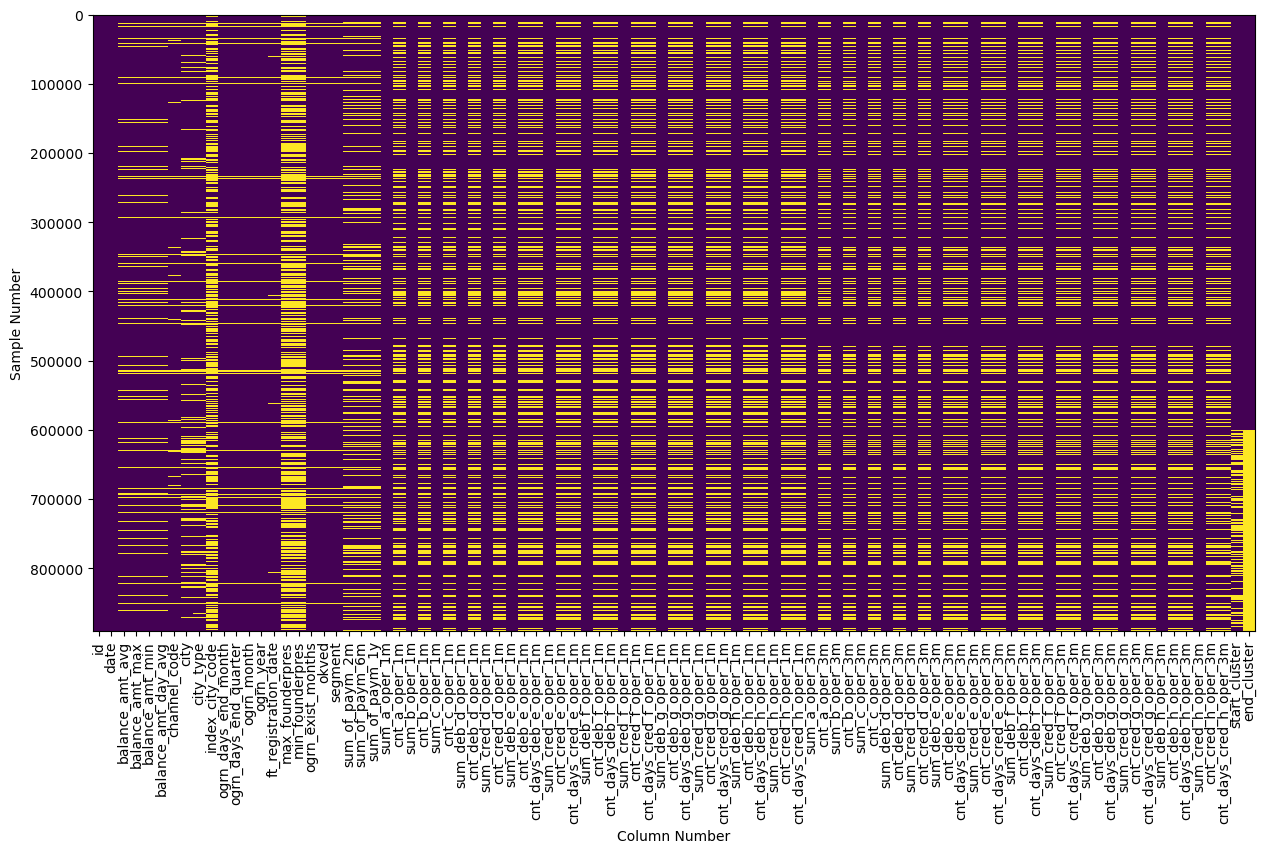

In [29]:
plt_null_df(df.isna())

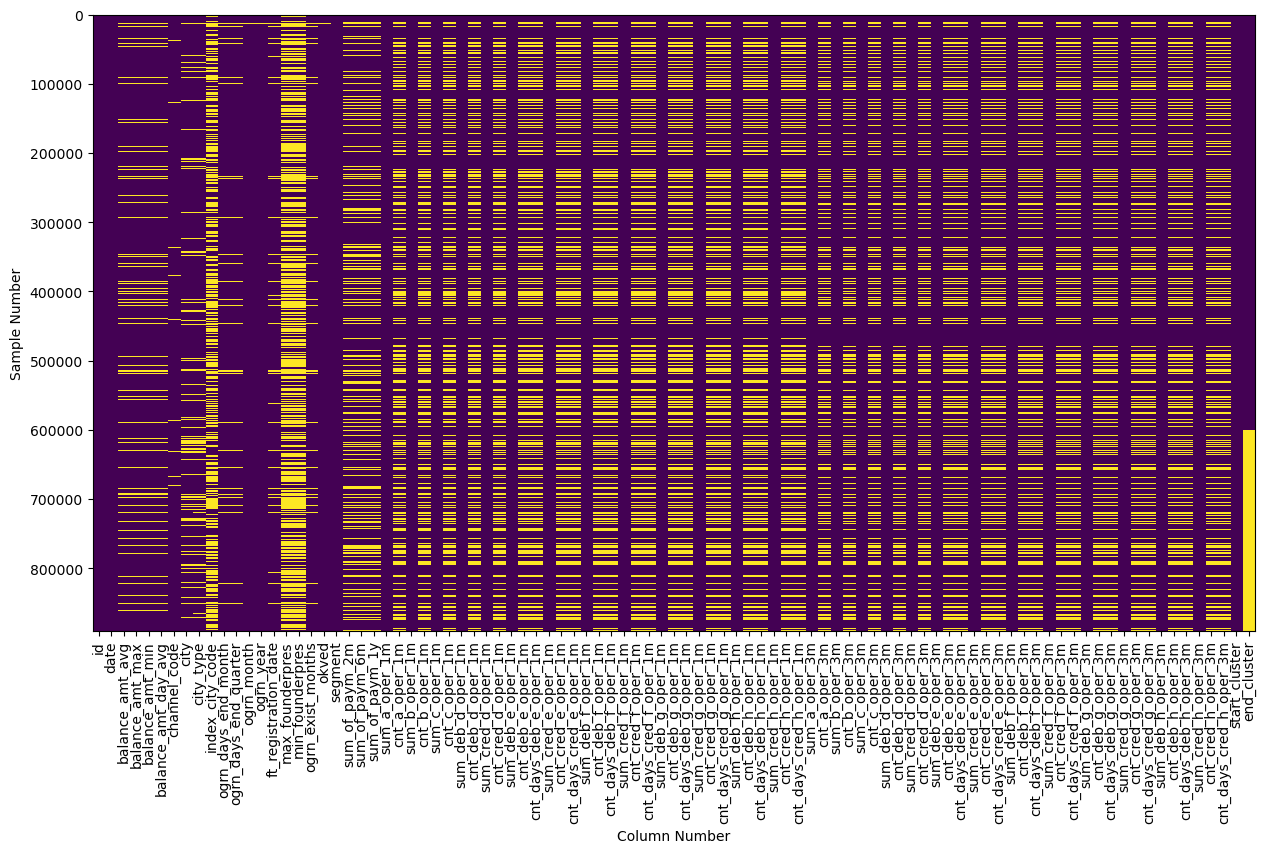

In [ ]:
plt_null_df(restored_cat_df.isna())

#### Клиенты, у которых во всех 3 месяцах nan

In [ ]:
nan_3_month_df = get_nan_3_month_df(get_df_low(16))
nan_3_month_df.to_parquet("../data/raw/nan_3_month_df.pqt")

nan_3_month_df = pd.read_parquet("../data/raw/nan_3_month_df.pqt")

In [ ]:
nan_3_month_df

id   date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0  False            False            False            False   
1            1  False            False            False            False   
2            2  False            False            False            False   
3            3  False            False            False            False   
4            4  False            False            False            False   
...        ...    ...              ...              ...              ...   
299995  299995  False            False            False            False   
299996  299996  False            False            False            False   
299997  299997  False            False            False            False   
299998  299998  False            False            False            False   
299999  299999  False            False            False            False   

        balance_amt_day_avg  channel_code   city  city_type  index_city_code  \
0                     False         False  False      False            False   
1                     False         False  False      False             True   
2                     False         False  False      False             True   
3                     False         False  False      False            False   
4                     False         False  False      False             True   
...                     ...           ...    ...        ...              ...   
299995                False         False  False      False            False   
299996                False         False  False      False            False   
299997                False         False  False      False            False   
299998                False         False  False      False            False   
299999                False         False  False      False            False   

        ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  sum_deb_h_oper_3m  \
0       ...               False                    False              False   
1       ...               False                    False              False   
2       ...               False                    False              False   
3       ...               False                    False              False   
4       ...               False                    False              False   
...     ...                 ...                      ...                ...   
299995  ...                True                     True              False   
299996  ...               False                    False              False   
299997  ...               False                    False              False   
299998  ...               False                    False              False   
299999  ...               False                    False              False   

        cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  sum_cred_h_oper_3m  \
0                   False                   False               False   
1                   False                   False               False   
2                   False                   False               False   
3                   False                   False               False   
4                   False                   False               False   
...                   ...                     ...                 ...   
299995               True                    True               False   
299996              False                   False               False   
299997              False                   False               False   
299998              False                   False               False   
299999              False                   False               False   

        cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  start_cluster  \
0                    False                    False          False   
1                    False                    False          False   
2                    False                    False          False   
3                    False      

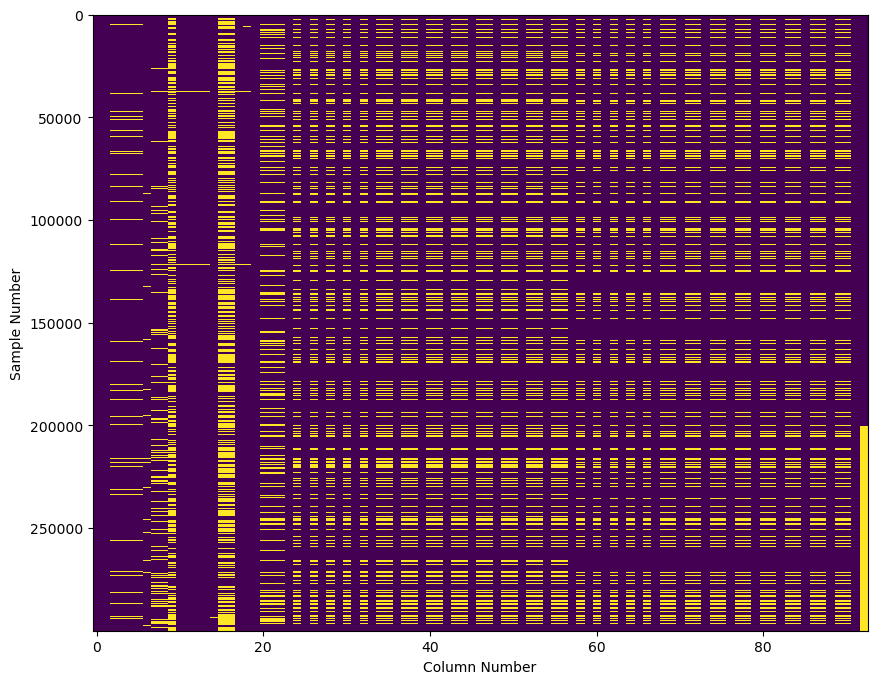

In [ ]:
plt_null_df(nan_3_month_df == True)

#### Значения клиентов, у которых нет 3. (Не работает логика дропнуть) ОНИ ТАКЖЕ НОРМАЛЬНО РАСПРЕДЕЛЕНЫ. НОРМ КЕНТЫ

In [ ]:
nan_values_3_month_df = get_nan_values_3_month_df(get_df_low(32))

date 7.0781941413879395
balance_amt_avg 8.79717493057251
balance_amt_max 8.858941078186035
balance_amt_min 8.963046073913574
balance_amt_day_avg 9.009438037872314
channel_code 9.107426166534424
city 8.963792085647583
city_type 8.878656148910522
index_city_code 10.189781904220581
ogrn_days_end_month 8.446223735809326
ogrn_days_end_quarter 8.705030918121338
ogrn_month 10.18896198272705
ogrn_year 10.09512972831726
ft_registration_date 8.427839994430542
max_founderpres 9.964420080184937
min_founderpres 9.958772897720337
ogrn_exist_months 8.308547019958496
okved 8.81621789932251
segment 10.805580854415894
sum_of_paym_2m 9.447249174118042
sum_of_paym_6m 9.24793815612793
sum_of_paym_1y 9.540246963500977
sum_a_oper_1m 7.029342174530029
cnt_a_oper_1m 10.756720781326294
sum_b_oper_1m 7.118927955627441
cnt_b_oper_1m 10.303900241851807
sum_c_oper_1m 6.986923933029175
cnt_c_oper_1m 10.442152261734009
sum_deb_d_oper_1m 7.35181999206543
cnt_deb_d_oper_1m 10.507116079330444
sum_cred_d_oper_1m 7.011410

In [ ]:
for column in df.select_dtypes(include= 'number' ).columns:
    if len(nan_values_3_month_df[column].value_counts()) < 20 and 'sum' not in column:
        print(column)

cnt_b_oper_1m
cnt_days_cred_f_oper_1m
cnt_b_oper_3m
cnt_days_cred_f_oper_3m


In [ ]:
nan_values_3_month_df["segment"].value_counts()

segment
segment_3    25957
segment_0     3258
segment_1     2300
segment_2     2142
Name: count, dtype: int64

In [ ]:
nan_values_3_month_df

id  date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0   NaN              NaN              NaN              NaN   
1            1   NaN              NaN              NaN              NaN   
2            2   NaN              NaN              NaN              NaN   
3            3   NaN              NaN              NaN              NaN   
4            4   NaN              NaN              NaN              NaN   
...        ...   ...              ...              ...              ...   
199995  199995   NaN              NaN              NaN              NaN   
199996  199996   NaN              NaN              NaN              NaN   
199997  199997   NaN              NaN              NaN              NaN   
199998  199998   NaN              NaN              NaN              NaN   
199999  199999   NaN              NaN              NaN              NaN   

        balance_amt_day_avg channel_code city city_type index_city_code  ...  \
0                       NaN          NaN  NaN       NaN             NaN  ...   
1                       NaN          NaN  NaN       NaN             NaN  ...   
2                       NaN          NaN  NaN       NaN             NaN  ...   
3                       NaN          NaN  NaN       NaN             NaN  ...   
4                       NaN          NaN  NaN       NaN             NaN  ...   
...                     ...          ...  ...       ...             ...  ...   
199995                  NaN          NaN  NaN       NaN             NaN  ...   
199996                  NaN          NaN  NaN       NaN             NaN  ...   
199997                  NaN          NaN  NaN       NaN             NaN  ...   
199998                  NaN          NaN  NaN       NaN             NaN  ...   
199999                  NaN          NaN  NaN       NaN             NaN  ...   

        cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m sum_deb_h_oper_3m  \
0                      NaN                      NaN               NaN   
1                      NaN                      NaN               NaN   
2                      NaN                      NaN               NaN   
3                      NaN                      NaN               NaN   
4                      NaN                      NaN               NaN   
...                    ...                      ...               ...   
199995                 NaN                      NaN               NaN   
199996                 NaN                      NaN               NaN   
199997                 NaN                      NaN               NaN   
199998              0.9445                   0.3848               NaN   
199999                 NaN                      NaN               NaN   

       cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  sum_cred_h_oper_3m  \
0                    NaN                     NaN                 NaN   
1                    NaN                     NaN                 NaN   
2                    NaN                     NaN                 NaN   
3                    NaN                     NaN                 NaN   
4                    NaN                     NaN                 NaN   
...                  ...                     ...                 ...   
199995               NaN                     NaN                 NaN   
199996               NaN                     NaN                 NaN   
199997               NaN                     NaN                 NaN   
199998            0.5469                  0.4077                 NaN   
199999               NaN                     NaN                 NaN   

        cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m start_cluster end_cluster  
0                      NaN                      NaN           NaN         NaN  
1                      NaN                      NaN           NaN         NaN  
2                      NaN                      NaN           NaN         NaN  
3                      NaN                      NaN           NaN         NaN  
4       

In [ ]:
nan_values_3_month_df['cnt_a_oper_1m'].value_counts().sort_index()

cnt_a_oper_1m
0.4170    31251
0.4217      967
0.4264      596
0.4310      389
0.4357      291
0.4404      164
0.4451      130
0.4497       81
0.4544       57
0.4591       42
0.4638       31
0.4684       20
0.4731       15
0.4778       11
0.4824        7
0.4871        8
0.4918        3
0.4965        7
0.5011        4
0.5058        4
0.5105        6
0.5198        3
0.5292        1
0.5338        1
0.5385        1
0.5432        1
0.5479        4
0.5525        1
0.5619        2
0.5666        1
0.5712        1
0.5759        2
0.5852        1
0.6086        1
0.6320        1
Name: count, dtype: int64

In [ ]:
nan_values_3_month_df.astype('str').to_parquet(
    "../data/raw/nan_values_3_month_df.pqt")

In [ ]:
nan_values_3_month_df = nan_values_3_month_df.astype('str')
nan_values_3_month_df.to_parquet("../data/raw/nan_values_3_month_df.pqt")

In [ ]:
nan_values_3_month_df = pd.read_parquet("../data/raw/nan_values_3_month_df.pqt")

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/nan_values_3_month_df.pqt'

In [ ]:
nan_values_3_month_df

### Уникальные значения

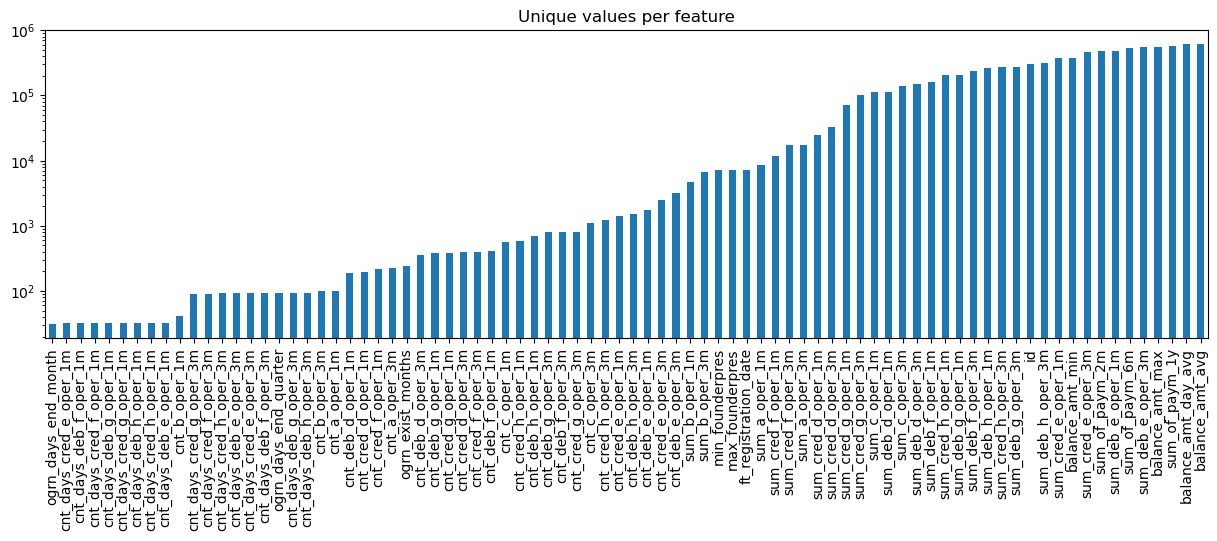

In [30]:
unique_values = df.select_dtypes(include="number").nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

#### Столбцы в которых много повторяющихся значений

In [60]:
def find_columns_with_high_repeated_values(df, threshold):
    columns_with_high_repeated_values = []
    for col in df.columns:
        value_counts = df[col].value_counts()
        if value_counts.max() >= threshold:
            columns_with_high_repeated_values.append(col)
    return columns_with_high_repeated_values


# Замените df на ваш датафрейм, а threshold на количество раз, которое значение должно встречаться, чтобы столбец попал в результат
threshold = 500000
columns_with_high_repeated_values = find_columns_with_high_repeated_values(
    df, threshold)
print("Столбцы, в которых значение встречается {} и более раз:".format(threshold))
print(columns_with_high_repeated_values)

Столбцы, в которых значение встречается 500000 и более раз:
['city_type', 'segment', 'sum_a_oper_1m', 'cnt_a_oper_1m', 'sum_b_oper_1m', 'cnt_b_oper_1m', 'sum_c_oper_1m', 'sum_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m', 'sum_deb_f_oper_1m', 'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_days_cred_f_oper_1m', 'sum_deb_g_oper_1m', 'sum_cred_g_oper_1m', 'sum_deb_h_oper_1m', 'sum_cred_h_oper_1m', 'sum_a_oper_3m', 'cnt_a_oper_3m', 'sum_b_oper_3m', 'cnt_b_oper_3m', 'sum_c_oper_3m', 'sum_deb_d_oper_3m', 'sum_cred_d_oper_3m', 'cnt_cred_d_oper_3m', 'sum_deb_f_oper_3m', 'sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m', 'cnt_days_cred_f_oper_3m', 'sum_deb_g_oper_3m', 'sum_cred_g_oper_3m']


#### Итог

Все хорошо

### Корреляция

#### Corr Full df

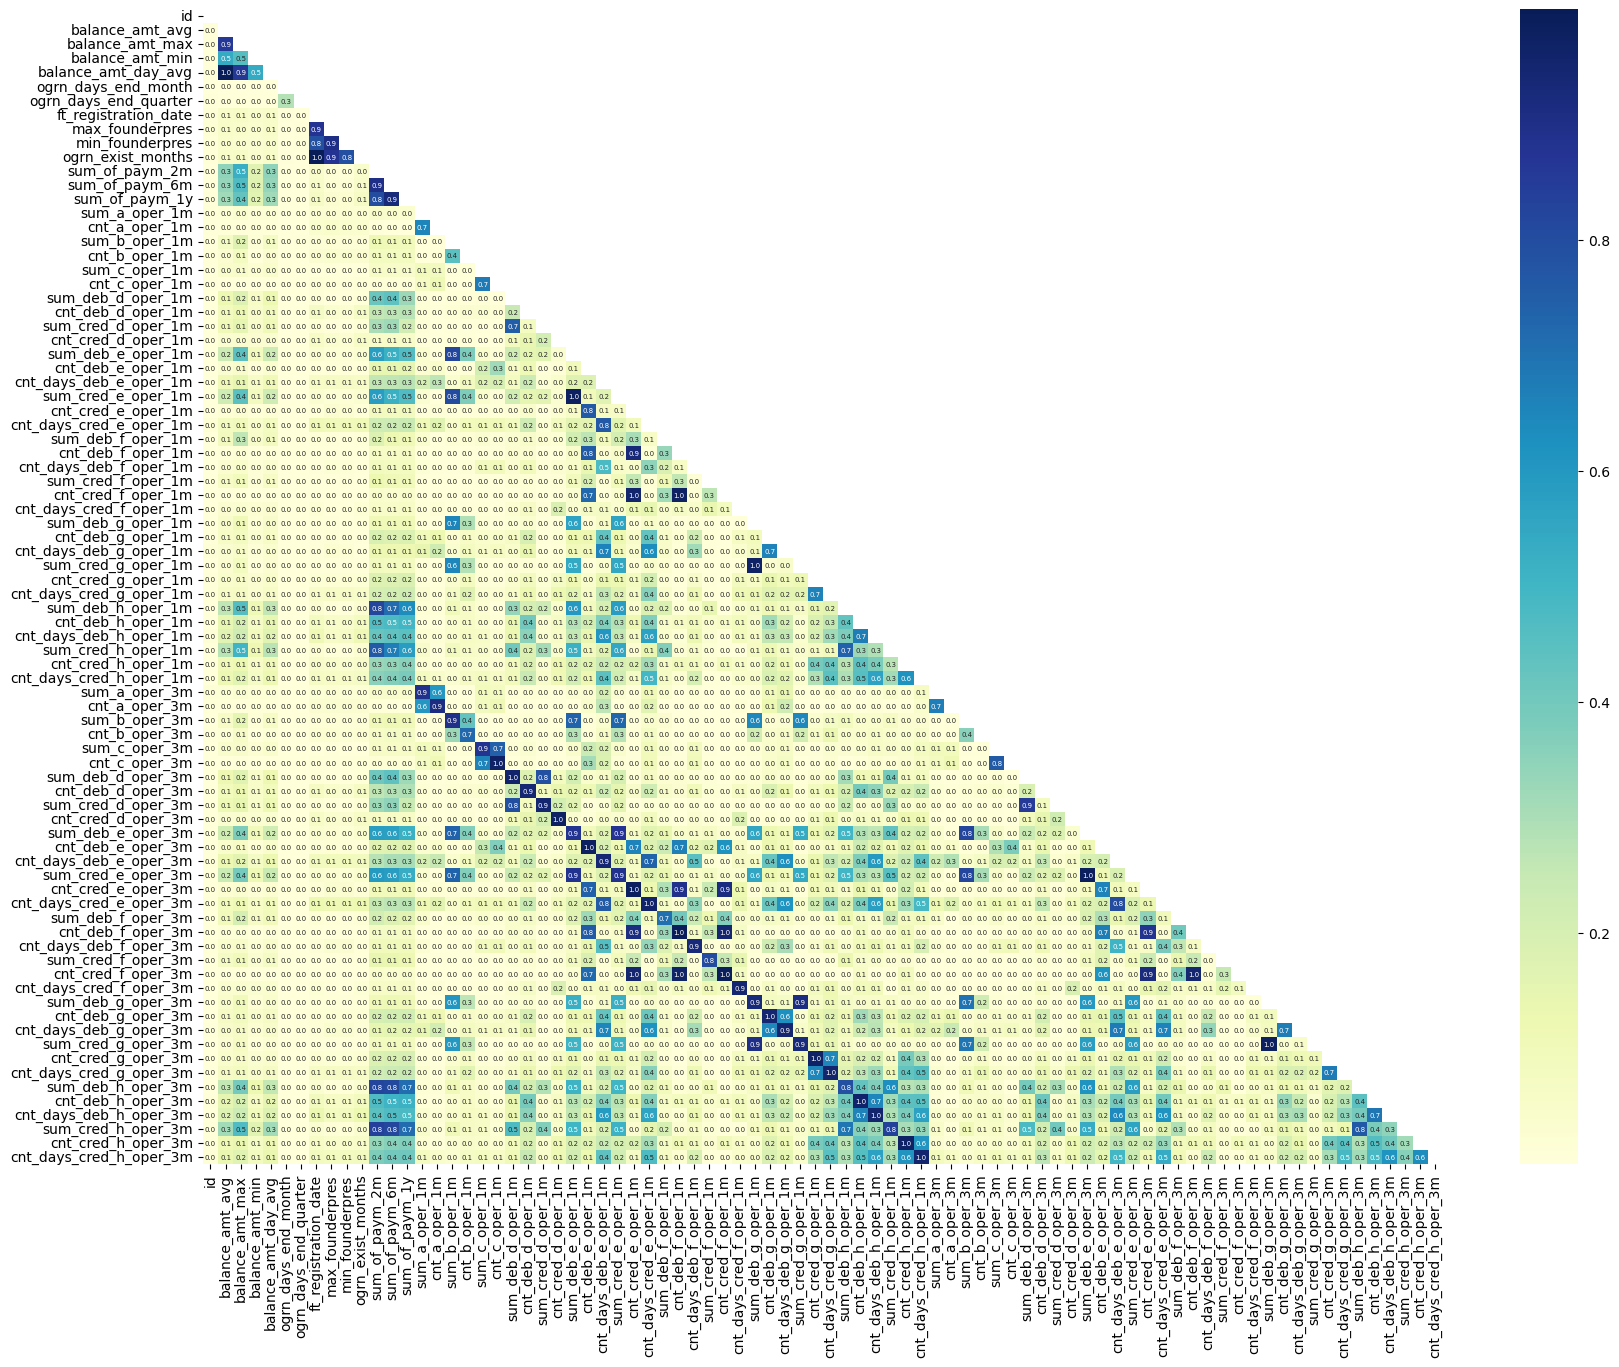

In [36]:
plt_corr_df(df)

In [37]:
get_columns_corr(df, p = 0.9)

{('ogrn_exist_months', 'ft_registration_date'): 0.9998762737464166,
 ('ft_registration_date', 'ogrn_exist_months'): 0.9998762737464166,
 ('balance_amt_avg', 'balance_amt_day_avg'): 0.9984710888922917,
 ('balance_amt_day_avg', 'balance_amt_avg'): 0.9984710888922917,
 ('cnt_cred_f_oper_1m', 'cnt_cred_f_oper_3m'): 0.9947826509914572,
 ('cnt_cred_f_oper_3m', 'cnt_cred_f_oper_1m'): 0.9947826509914572,
 ('cnt_deb_f_oper_1m', 'cnt_deb_f_oper_3m'): 0.9935044458891936,
 ('cnt_deb_f_oper_3m', 'cnt_deb_f_oper_1m'): 0.9935044458891936,
 ('cnt_cred_e_oper_1m', 'cnt_cred_e_oper_3m'): 0.985436795276794,
 ('cnt_cred_e_oper_3m', 'cnt_cred_e_oper_1m'): 0.985436795276794,
 ('sum_cred_e_oper_3m', 'sum_deb_e_oper_3m'): 0.98534151074155,
 ('sum_deb_e_oper_3m', 'sum_cred_e_oper_3m'): 0.98534151074155,
 ('sum_deb_e_oper_1m', 'sum_cred_e_oper_1m'): 0.9793286515432401,
 ('sum_cred_e_oper_1m', 'sum_deb_e_oper_1m'): 0.9793286515432401,
 ('cnt_deb_e_oper_3m', 'cnt_deb_e_oper_1m'): 0.9791128053215934,
 ('cnt_deb_e_

In [ ]:
get_columns_corr(df.drop(columns=stats_1m), p = 0.7)

{('ogrn_exist_months', 'ft_registration_date'): 0.9998762737464166,
 ('ft_registration_date', 'ogrn_exist_months'): 0.9998762737464166,
 ('balance_amt_day_avg', 'balance_amt_avg'): 0.9984710888922919,
 ('balance_amt_avg', 'balance_amt_day_avg'): 0.9984710888922919,
 ('sum_cred_e_oper_3m', 'sum_deb_e_oper_3m'): 0.9853415107415499,
 ('sum_deb_e_oper_3m', 'sum_cred_e_oper_3m'): 0.9853415107415499,
 ('sum_cred_g_oper_3m', 'sum_deb_g_oper_3m'): 0.9786793015679323,
 ('sum_deb_g_oper_3m', 'sum_cred_g_oper_3m'): 0.9786793015679323,
 ('cnt_deb_f_oper_3m', 'cnt_cred_f_oper_3m'): 0.9529850696937997,
 ('cnt_cred_f_oper_3m', 'cnt_deb_f_oper_3m'): 0.9529850696937997,
 ('sum_of_paym_6m', 'sum_of_paym_1y'): 0.927029441880188,
 ('sum_of_paym_1y', 'sum_of_paym_6m'): 0.927029441880188,
 ('cnt_cred_e_oper_3m', 'cnt_cred_f_oper_3m'): 0.9194226580990756,
 ('cnt_cred_f_oper_3m', 'cnt_cred_e_oper_3m'): 0.9194226580990756,
 ('max_founderpres', 'min_founderpres'): 0.9055825289892422,
 ('min_founderpres', 'max_f

### Выбросы

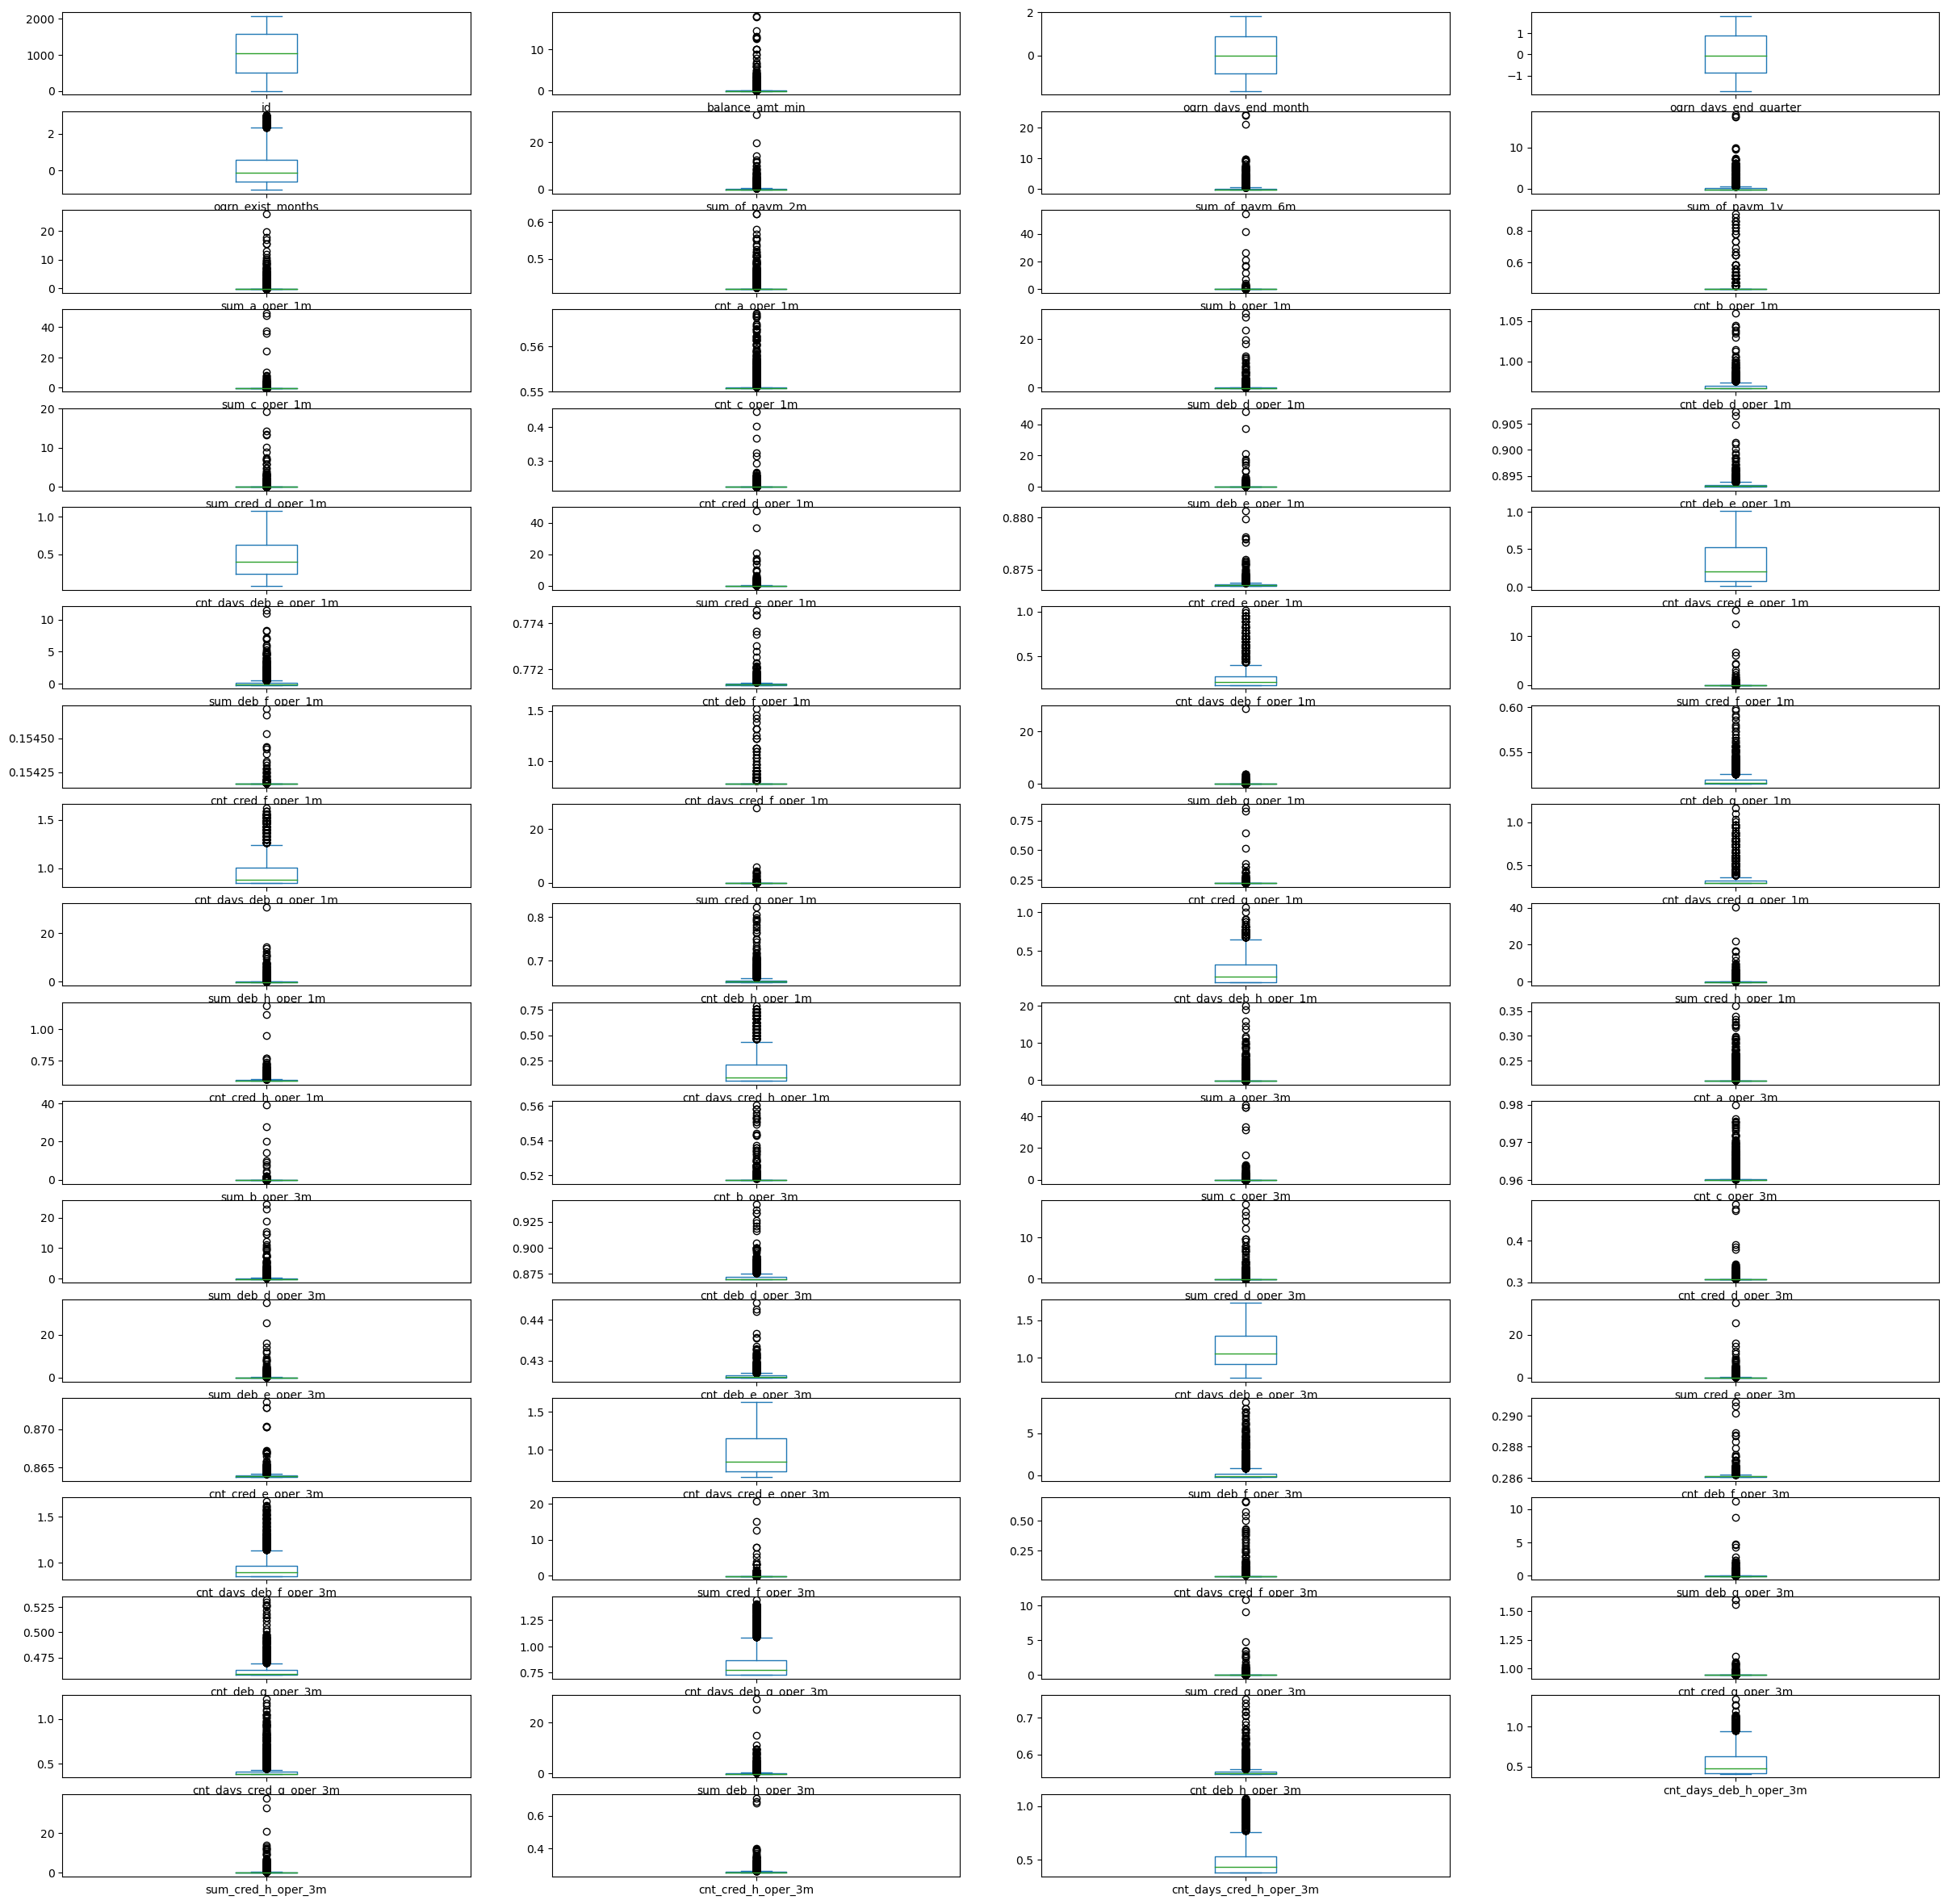

In [215]:
df[df.select_dtypes(include='number').columns][:3000].plot(kind='box', subplots=True, layout=(-1, 4),
                                                           figsize=(30, 30))

plt.show()

In [217]:
# def remove_outliers(df, k=1.5):
#     # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
#     df_cleaned = df.copy()

#     # Итерируемся по каждому числовому столбцу
#     for column in df_cleaned.select_dtypes(include='number').columns:
#         # Вычисляем квартили
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)

#         # Вычисляем межквартильный размах (IQR)
#         IQR = Q3 - Q1

#         # Определяем верхнюю и нижнюю границы для выбросов
#         lower_bound = Q1 - k * IQR
#         upper_bound = Q3 + k * IQR

#         # Заменяем значения за пределами границ на минимальное и максимальное значение
#         df_cleaned[column] = df_cleaned[column].clip(
#             lower=lower_bound, upper=upper_bound)

#     return df_cleaned


# # Применяем функцию к DataFrame, чтобы избавиться от выбросов
# df = remove_outliers(df)

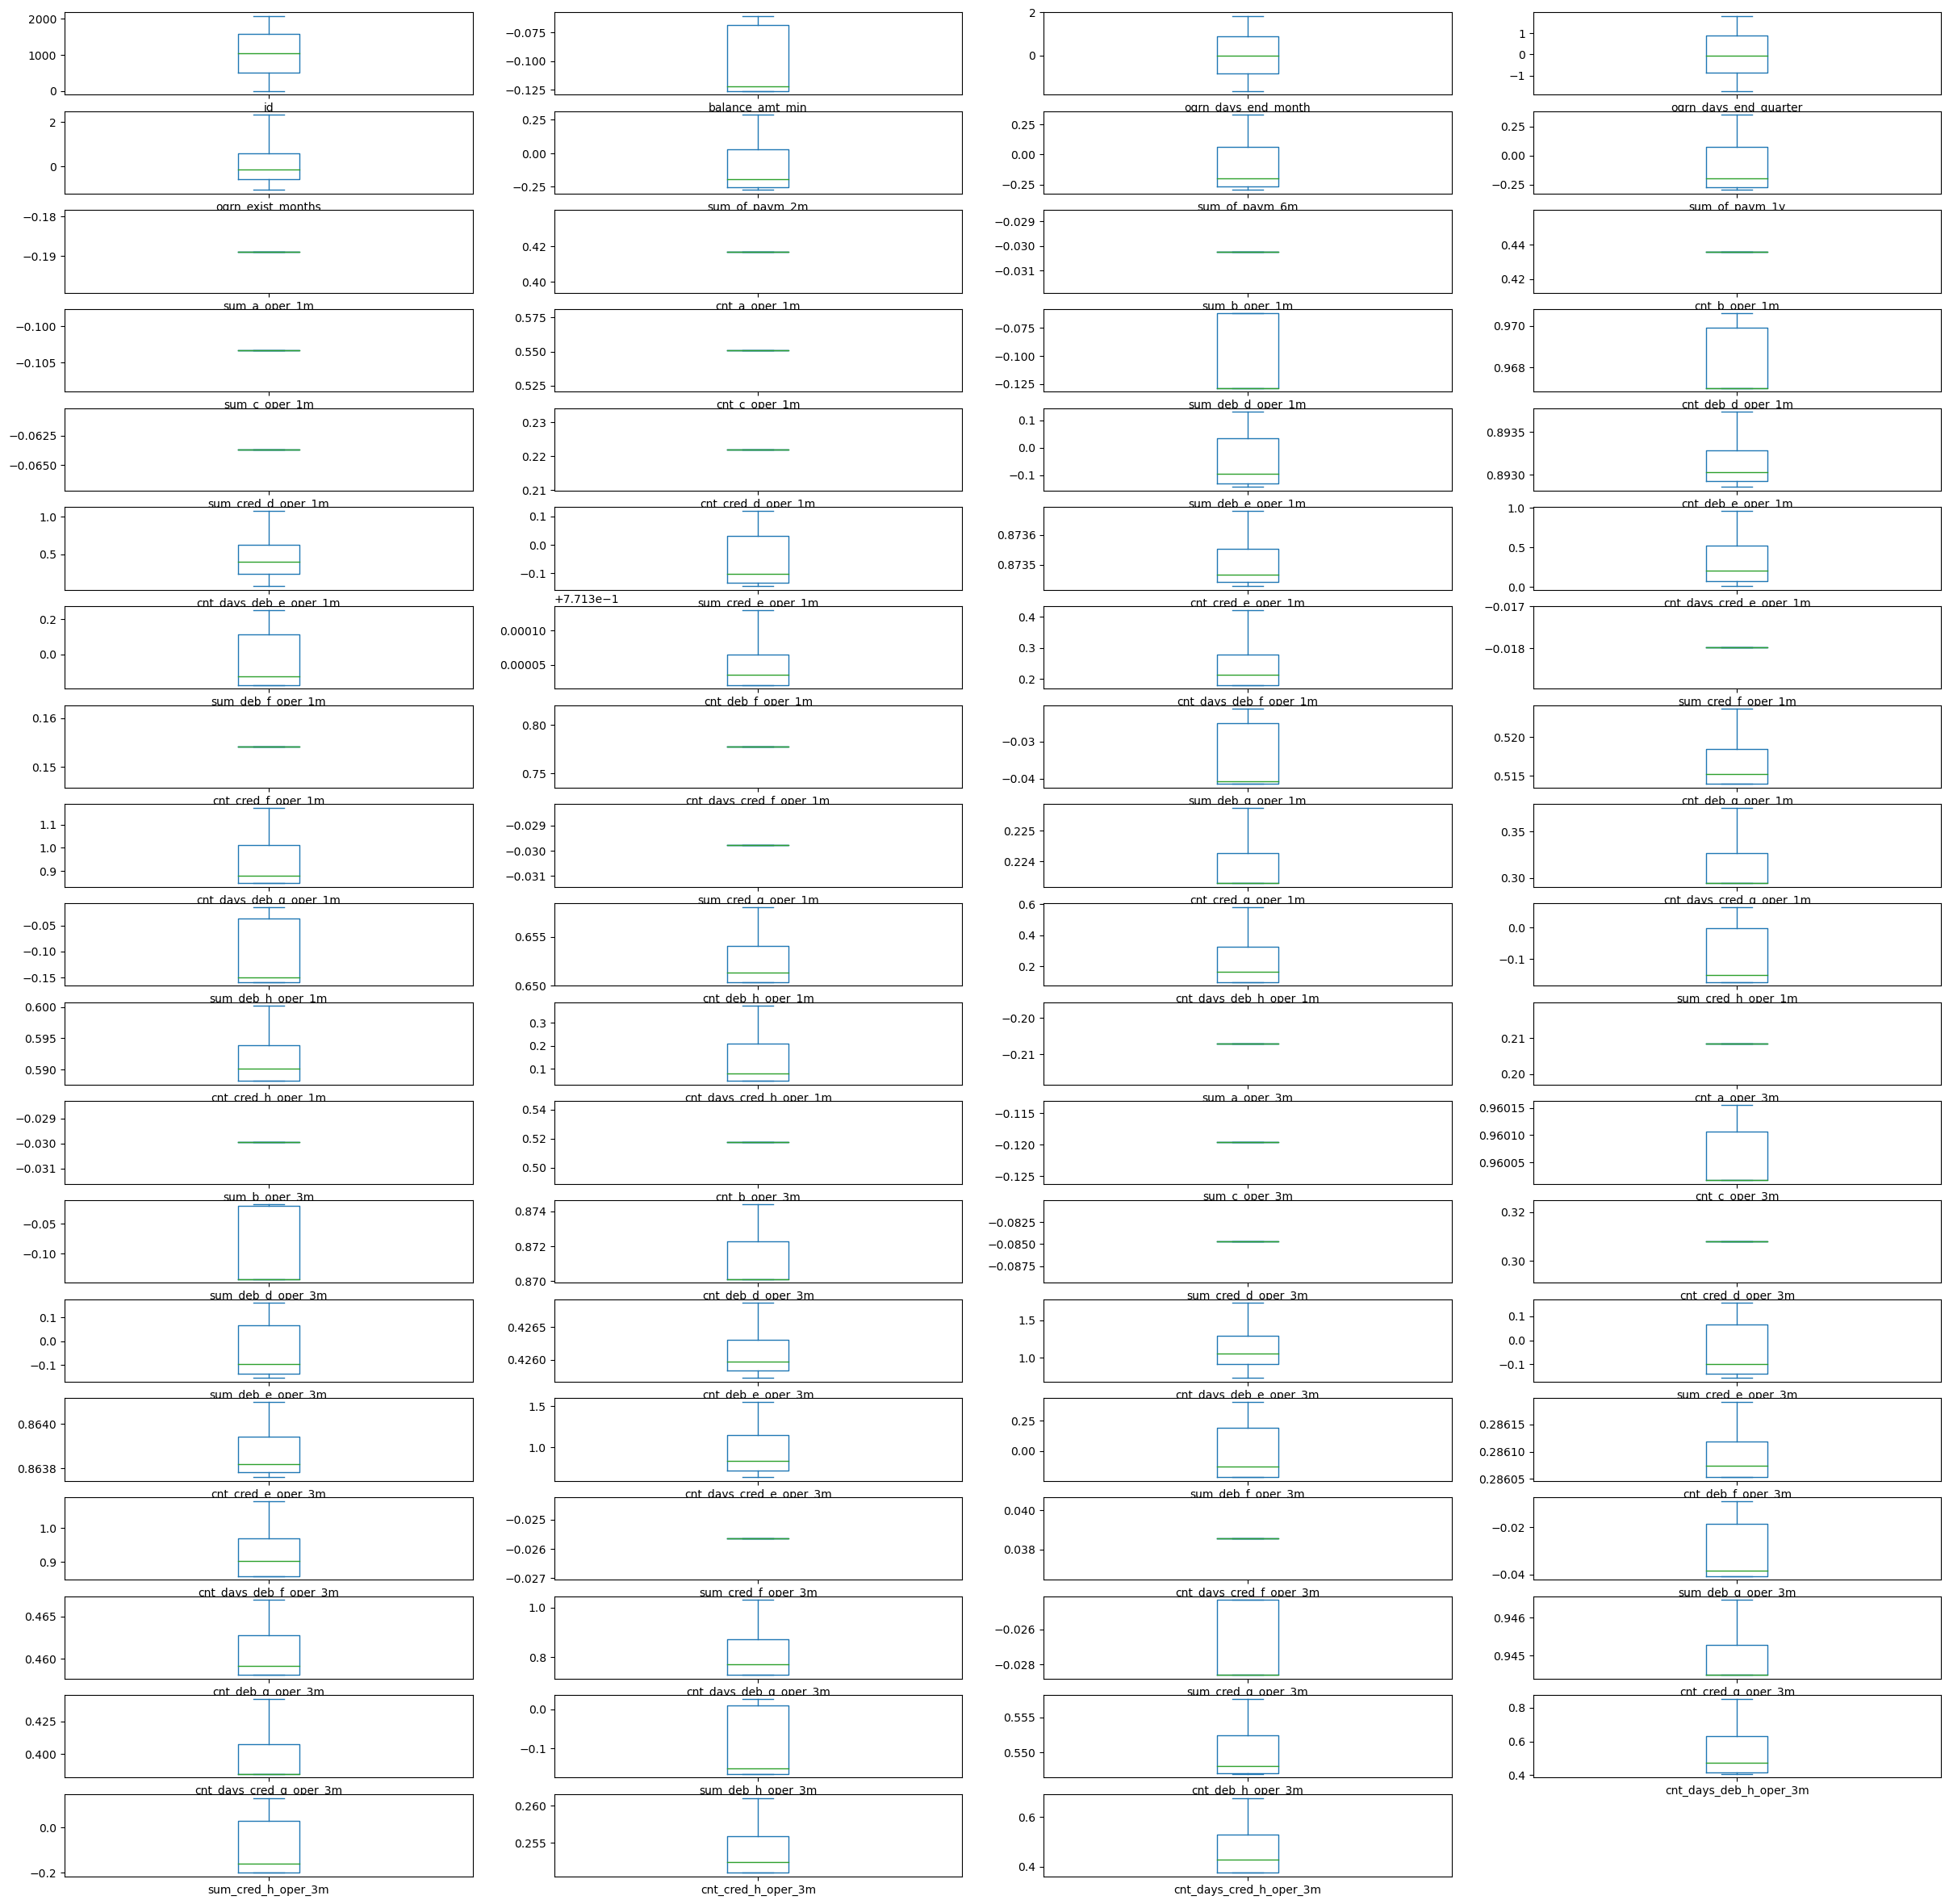

In [218]:
df[df.select_dtypes(include='number').columns][:3000].plot(kind='box', subplots=True, layout=(-1, 4),
                                                           figsize=(30, 30))

plt.show()

#### Итог

Слишком много выбросов возможно это из за плохих столбцов

### Графики

- `lw=0`: Толщина линии графика установлена на 0, что означает отсутствие линии (то есть только точки).
- `marker="."`: Точечный маркер, который будет использоваться на графиках.
- `subplots=True`: Создает отдельные графики для каждого столбца данных.
- `layout=(-1, 4)`: Устанавливает макет для размещения графиков. Здесь `(-1, 4)` означает, что количество строк (-1) будет определено автоматически в зависимости от количества выбранных столбцов, а количество столбцов (4) останется постоянным.
- `figsize=(15, 15)`: Размер фигуры, в данном случае 15x15 дюймов.
- `markersize=1`: Размер маркеров точек на графике.

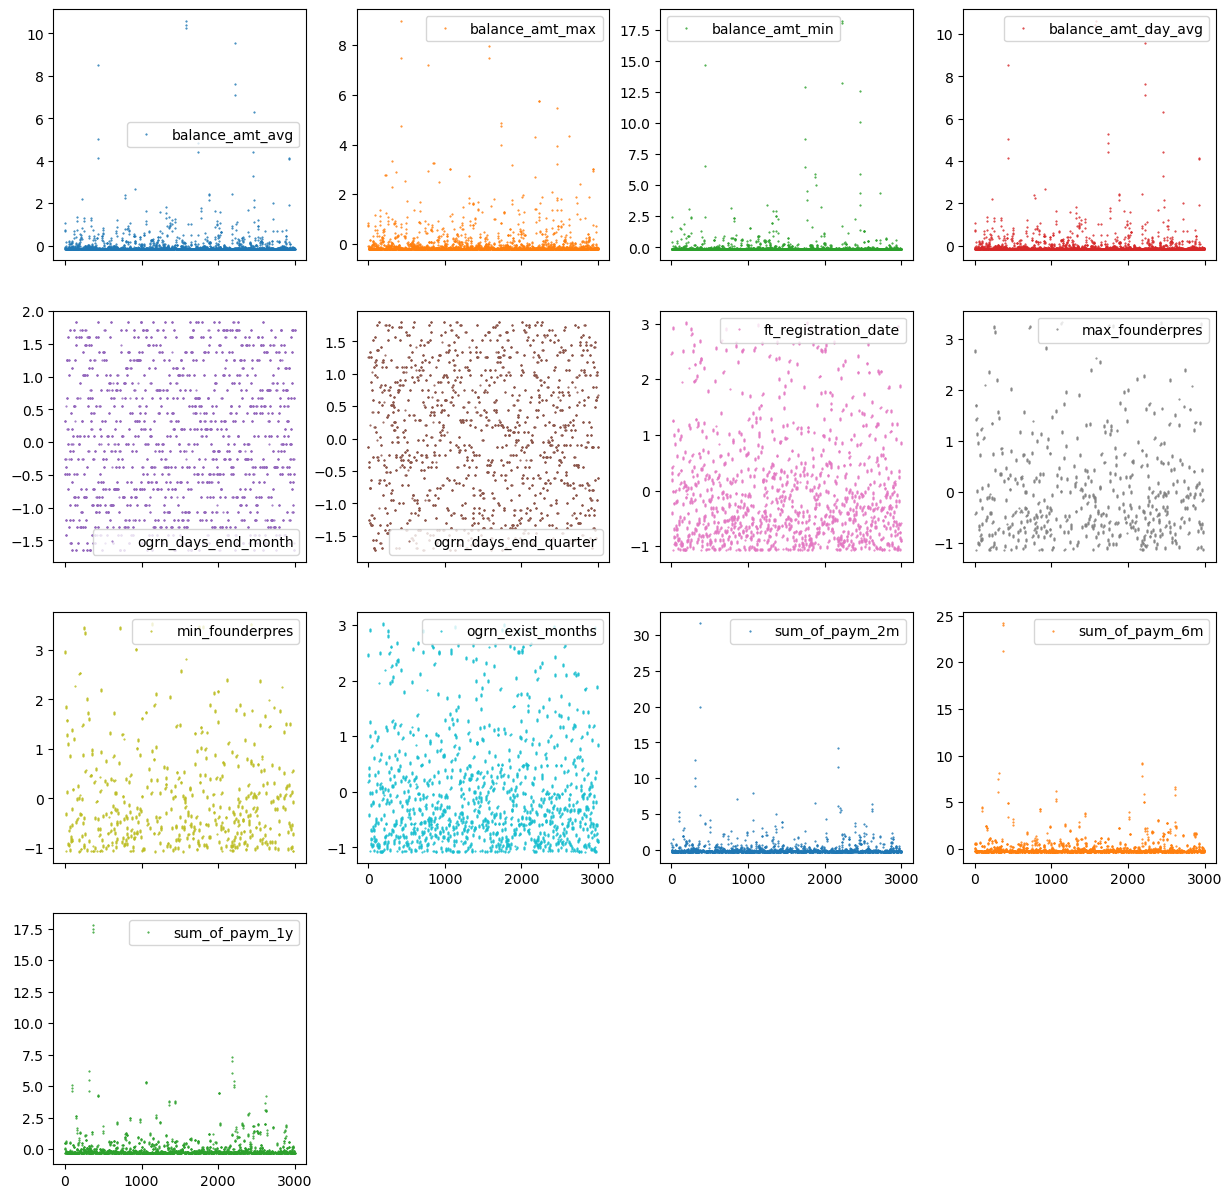

In [ ]:
df[stats][:3000].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 15), markersize=1);

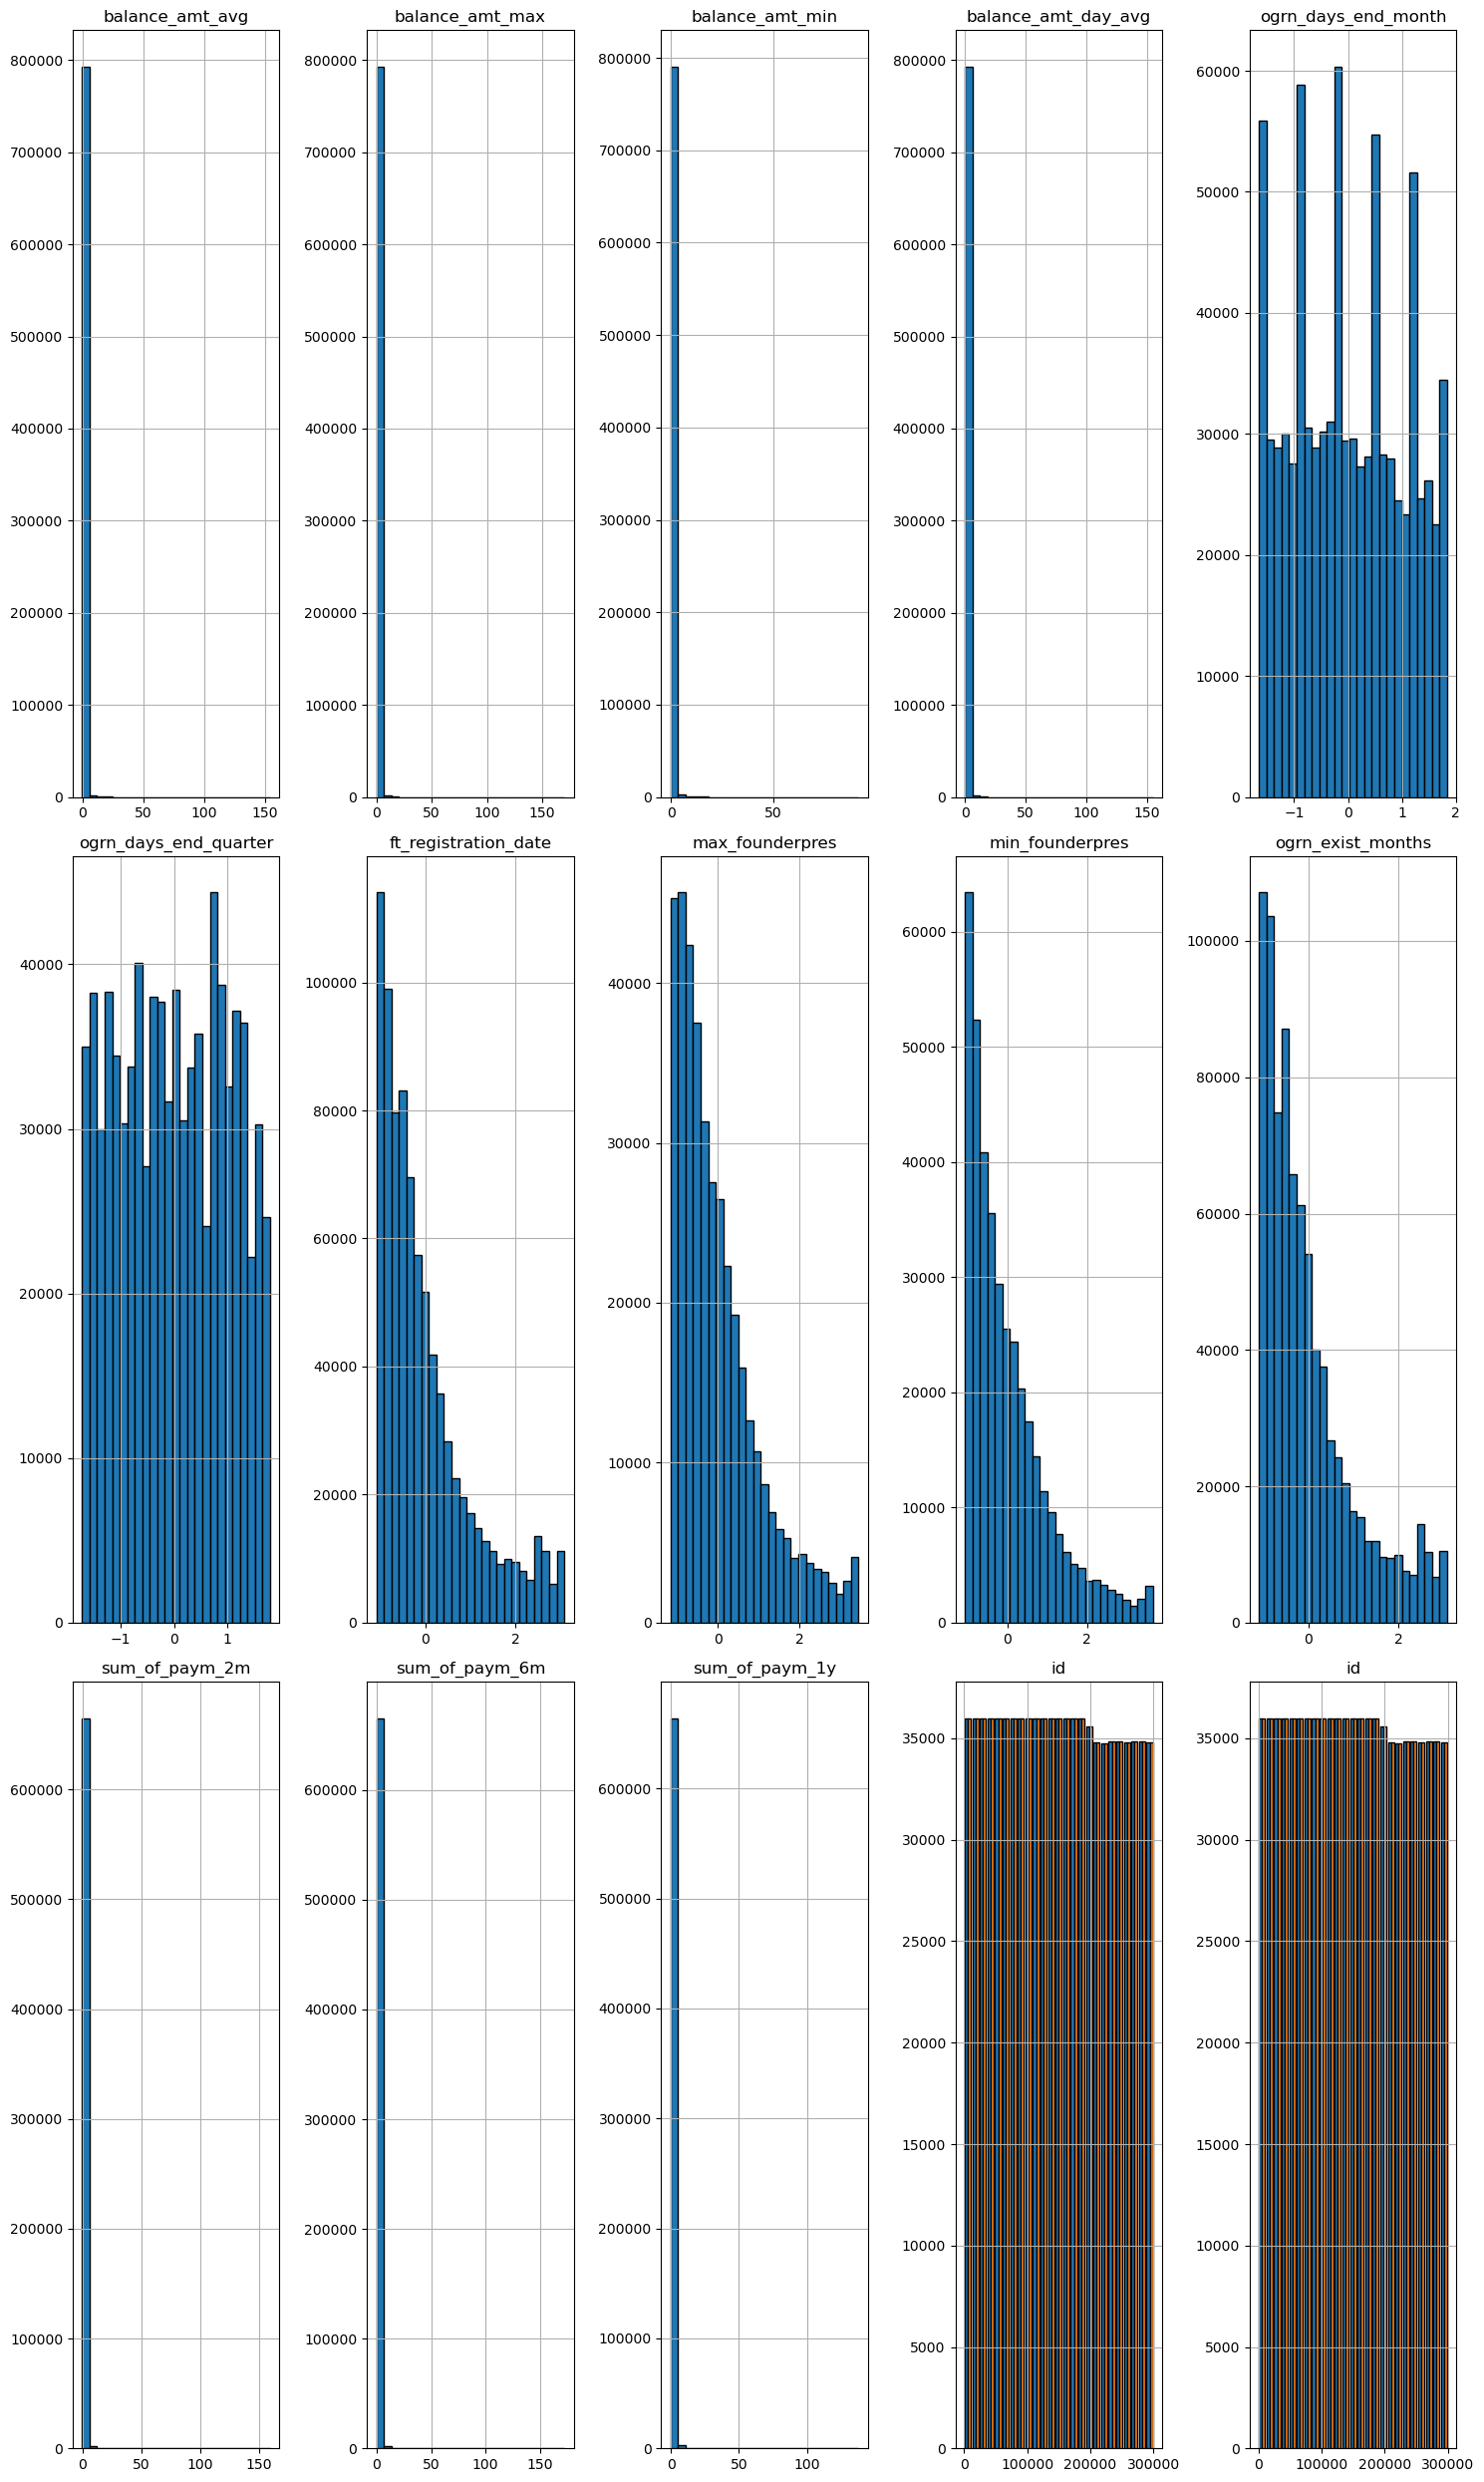

In [ ]:
df[stats].hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

<Axes: >

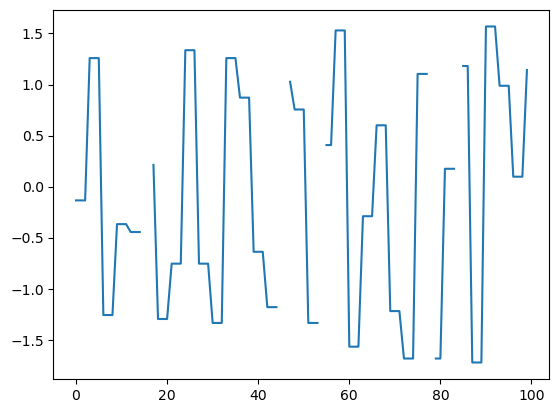

In [ ]:
df["f"][:100].plot(kind='line')

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

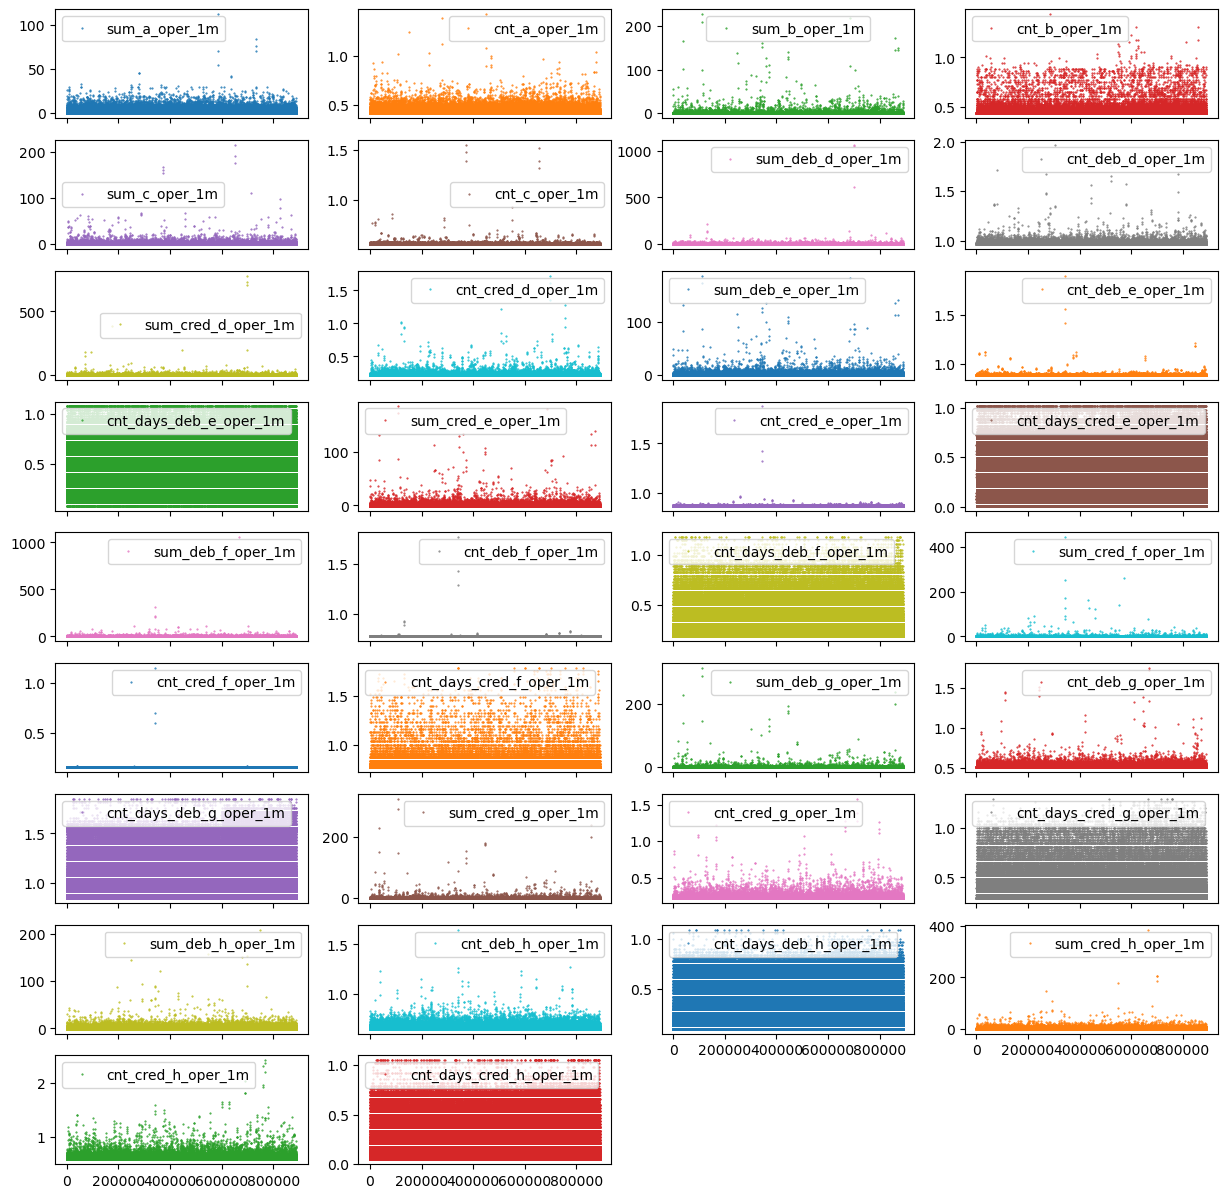

In [161]:
df[stats_1m].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
               figsize=(15, 15), markersize=1)

In [ ]:
df[""].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
                  figsize=(15, 15), markersize=1)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

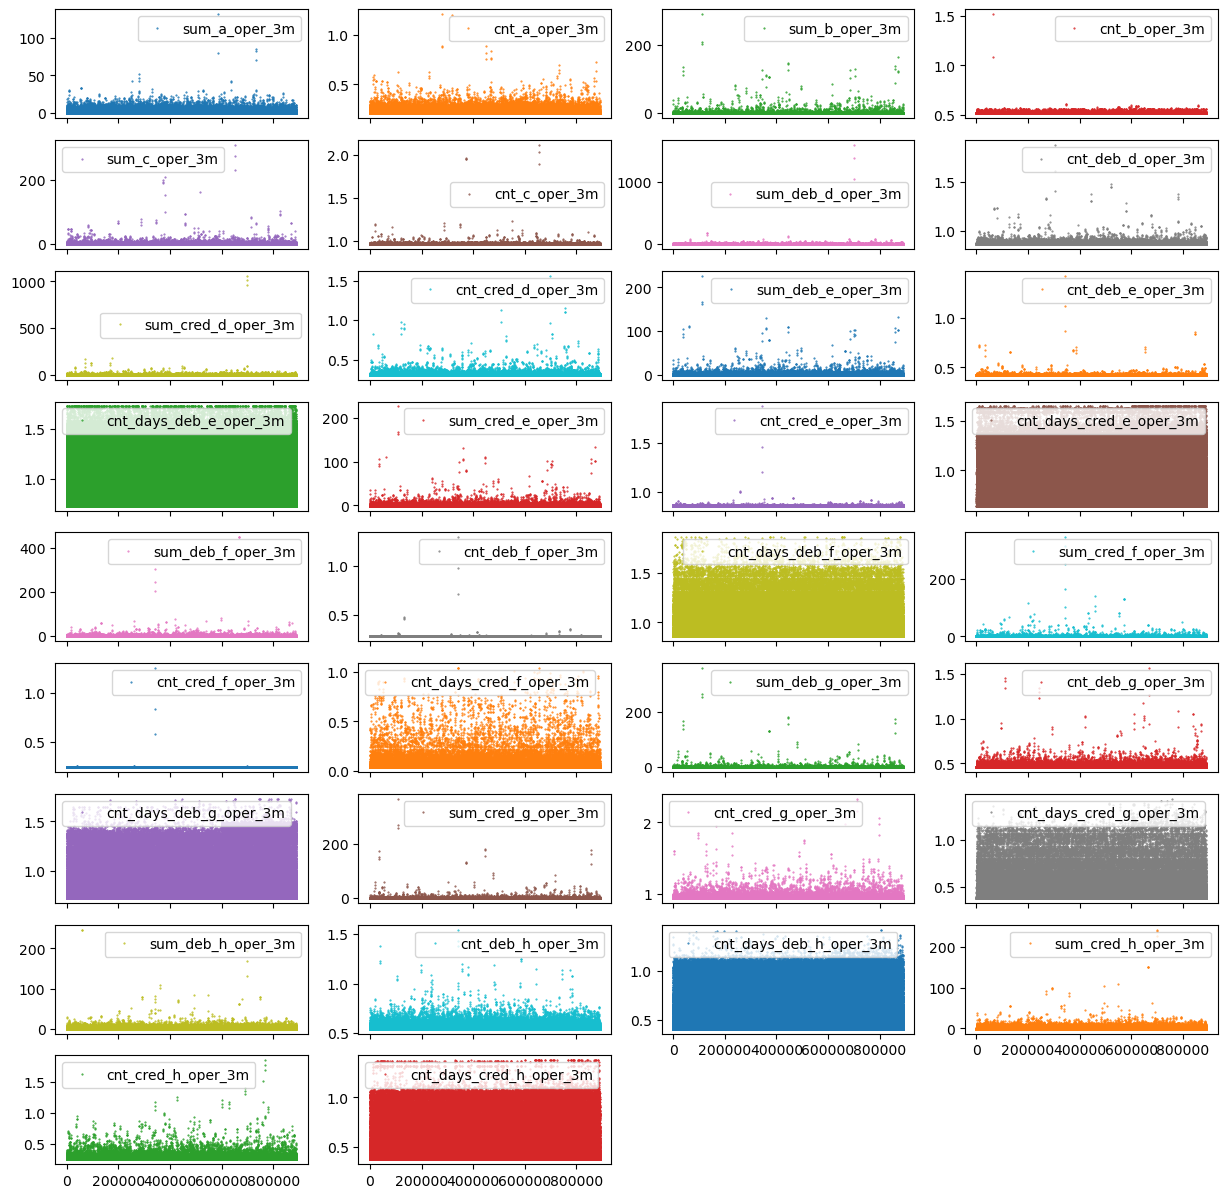

In [ ]:
df[stats_3m].plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
                  figsize=(15, 15), markersize=1)

In [ ]:
df[stats_cat]

date    channel_code     city    city_type     index_city_code  \
0       month_1  channel_code_5  city_23  city_type_0  index_city_code_39   
1       month_2  channel_code_5  city_23  city_type_0  index_city_code_39   
2       month_3  channel_code_5  city_23  city_type_0  index_city_code_39   
3       month_1  channel_code_2  city_14  city_type_0                None   
4       month_2  channel_code_2  city_14  city_type_0                None   
...         ...             ...      ...          ...                 ...   
890115  month_5            None     None         None                None   
890116  month_6  channel_code_9  city_25  city_type_0  index_city_code_30   
890117  month_4  channel_code_9   city_6  city_type_0  index_city_code_34   
890118  month_5  channel_code_9   city_6  city_type_0  index_city_code_34   
890119  month_6  channel_code_9   city_6  city_type_0  index_city_code_34   

           ogrn_month     ogrn_year     okved    segment start_cluster  \
0        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
1        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
2        ogrn_month_0   ogrn_year_1  okved_30  segment_1        {α, γ}   
3        ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}   
4        ogrn_month_5  ogrn_year_15   okved_5  segment_1       {other}   
...               ...           ...       ...        ...           ...   
890115            NaN           NaN      None        NaN            {}   
890116   ogrn_month_8  ogrn_year_11  okved_17  segment_2           NaN   
890117  ogrn_month_11  ogrn_year_14  okved_17  segment_3           {α}   
890118  ogrn_month_11  ogrn_year_14  okved_17  segment_3           {α}   
890119  ogrn_month_11  ogrn_year_14  okved_17  segment_3           NaN   

       end_cluster  
0          {other}  
1          {other}  
2          {other}  
3          {other}  
4          {other}  
...            ...  
890115        None  
890116        None  
890117        None  
890118        None  
890119        None  

[890120 rows x 11 columns]

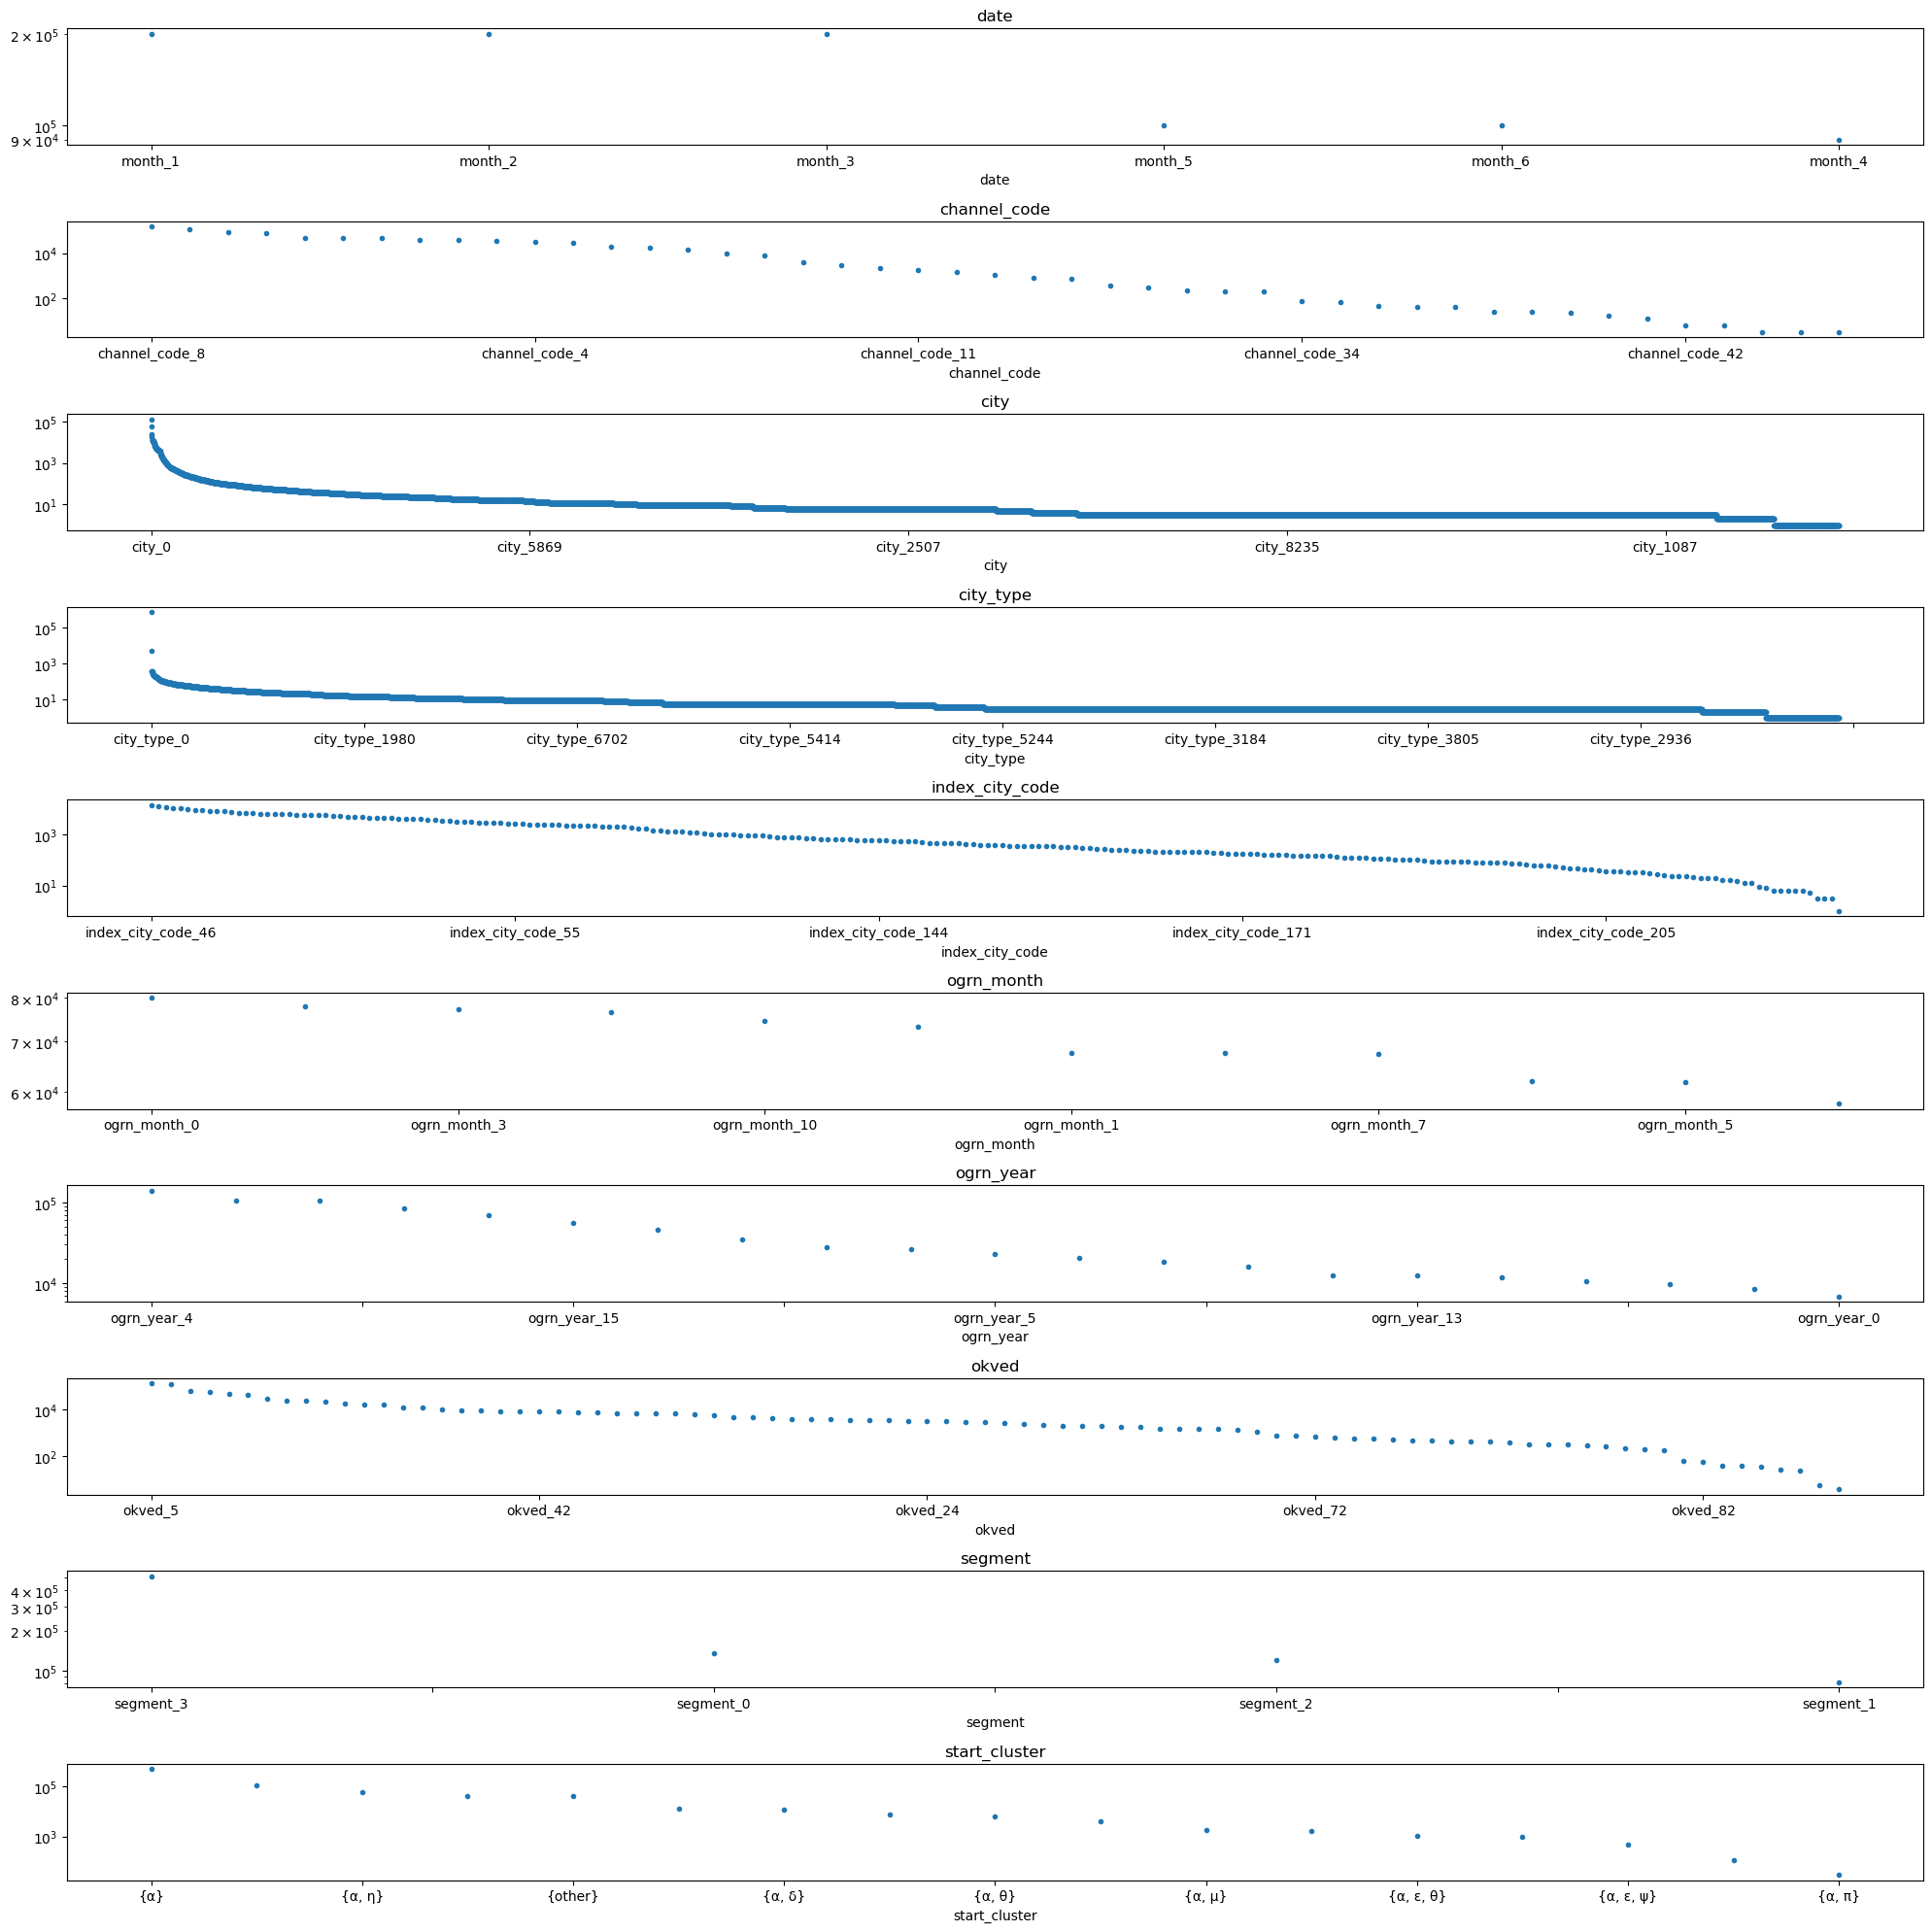

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=10, figsize=(20, 20))

# Identify non-numerical features
df_non_numerical = df.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)

plt.tight_layout()

### Clusters

In [51]:
df['end_cluster'].value_counts()

end_cluster
{α}          318670
{}           122366
{other}       47197
{α, η}        40810
{α, γ}        34471
{α, β}        11203
{α, θ}         6511
{α, ε}         5450
{α, δ}         4078
{α, ψ}         2929
{α, μ}         2123
{α, ε, η}      1674
{α, ε, θ}      1125
{α, λ}          873
{α, ε, ψ}       361
{λ}             140
{α, π}           19
Name: count, dtype: int64

In [54]:
df[df['end_cluster'] == "{α, π}"].T

53328              53329   \
id                                   17776              17776   
date                               month_1            month_2   
balance_amt_avg                    -0.1319            -0.1421   
balance_amt_max                    -0.1067            -0.1453   
balance_amt_min                    -0.1259            -0.1256   
balance_amt_day_avg                -0.1314            -0.1416   
channel_code                channel_code_0     channel_code_0   
city                                city_0             city_0   
city_type                      city_type_0        city_type_0   
index_city_code          index_city_code_3  index_city_code_3   
ogrn_days_end_month                 1.3695             1.3695   
ogrn_days_end_quarter               1.6459             1.6459   
ogrn_month                   ogrn_month_10      ogrn_month_10   
ogrn_year                     ogrn_year_20       ogrn_year_20   
ft_registration_date                0.5459             0.5636   
max_founderpres                     0.6349             0.6545   
min_founderpres                     0.7651             0.7852   
ogrn_exist_months                   0.5418             0.5592   
okved                              okved_4            okved_4   
segment                          segment_0          segment_0   
sum_of_paym_2m                      0.4534             0.3874   
sum_of_paym_6m                      0.3837             0.3867   
sum_of_paym_1y                      0.5671             0.5673   
sum_a_oper_1m                      -0.1888            -0.1888   
cnt_a_oper_1m                       0.4170             0.4170   
sum_b_oper_1m                      -0.0302            -0.0302   
cnt_b_oper_1m                       0.4360             0.4360   
sum_c_oper_1m                      -0.1034            -0.1034   
cnt_c_oper_1m                       0.5508             0.5508   
sum_deb_d_oper_1m                  -0.1285            -0.1285   
cnt_deb_d_oper_1m                   0.9670             0.9670   
sum_cred_d_oper_1m                 -0.0506            -0.0557   
cnt_cred_d_oper_1m                  0.2279             0.2260   
sum_deb_e_oper_1m                   0.4079             0.2428   
cnt_deb_e_oper_1m                   0.8935             0.8934   
cnt_days_deb_e_oper_1m              0.5279             0.4957   
sum_cred_e_oper_1m                  0.4050             0.2354   
cnt_cred_e_oper_1m                  0.8746             0.8742   
cnt_days_cred_e_oper_1m             0.6233             0.4942   
sum_deb_f_oper_1m                  -0.1736             0.2311   
cnt_deb_f_oper_1m                   0.7713             0.7714   
cnt_days_deb_f_oper_1m              0.1803             0.2448   
sum_cred_f_oper_1m                 -0.0180            -0.0180   
cnt_cred_f_oper_1m                  0.1542             0.1542   
cnt_days_cred_f_oper_1m             0.7777             0.7777   
sum_deb_g_oper_1m                   0.4859             0.2001   
cnt_deb_g_oper_1m                   0.5326             0.5249   
cnt_days_deb_g_oper_1m              1.1391             1.0746   
sum_cred_g_oper_1m                  0.0101             0.0248   
cnt_cred_g_oper_1m                  0.2282             0.2282   
cnt_days_cred_g_oper_1m             0.4560             0.4560   
sum_deb_h_oper_1m                   0.3131             0.2268   
cnt_deb_h_oper_1m                   0.6617             0.6630   
cnt_days_deb_h_oper_1m              0.4524             0.3879   
sum_cred_h_oper_1m                  0.7091             0.1985   
cnt_cred_h_oper_1m                  0.7725             0.7049   
cnt_days_cred_h_oper_1m             0.5971             0.5003   
sum_a_oper_3m                      -0.2071            -0.2071   
cnt_a_oper_3m                       0.2085             0.2085   
sum_b_oper_3m                      -0.0300            -0.0300   
cnt_b_oper_3m                       0.5173             0.5173   
sum_c_

In [ ]:
df1 = df.copy()
df1 = df1[['start_cluster', 'end_cluster']].dropna()

In [ ]:
spec_vals = ['α', 'β', 'γ', 'ε', 'ψ', 'δ', 'η', 'μ', 'λ', 'θ', 'π',
             'other', 'empty', 'None']

df['start_cluster'] = df['start_cluster'].str.strip('{}')
df['start_cluster'].fillna('None', inplace=True)
for col in spec_vals:
    df[f'start_cluster_{col}'] = 0
    df[f'start_cluster_{col}'] = train_df['start_cluster'].apply(lambda x: 1 if col in x else 0)

df['start_cluster_empty'] = df['start_cluster'].apply(lambda x: 1 if '{}' in x else 0)
df = df.drop(columns=['start_cluster'])


In [ ]:
spec_vals = ['α', 'β', 'γ', 'ε', 'ψ', 'δ', 'η', 'μ', 'λ', 'θ', 'π',
             'other', 'empty', 'None']

df['end_cluster'] = df['end_cluster'].str.strip('{}')
df['end_cluster'].fillna('None', inplace=True)
for col in spec_vals:
    df[f'end_cluster{col}'] = 0
    df[f'end_cluster{col}'] = train_df['end_cluster'].apply(lambda x: 1 if col in x else 0)

df['end_cluster_empty'] = df['end_cluster'].apply(lambda x: 1 if '{}' in x else 0)
df = df.drop(columns=['end_cluster'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["start_cluster", "end_cluster"]

label_encoders = {}
le = LabelEncoder()
le.fit(df1['start_cluster'].unique())


for col in cat_cols:
    df1[col] = le.transform(df1[col].dropna())


In [ ]:
plt_corr_df(df[[column for column in df.columns if 'cluster' in column]])

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 2000x1500 with 0 Axes>

###  Итоги

1.   Убрать `ogrn_days_end_month` - мало уникальных значений. ЭТО КОЛЛИЕЧСТВО ДНЕЙ В МЕСЯЦЕ

In [25]:
df['ogrn_days_end_month'].value_counts()

ogrn_days_end_month
-0.3724    30990
-0.7208    30495
-0.2563    30353
-0.4886    30213
-1.1853    30047
-0.1402    29984
-0.8369    29925
0.0921     29611
-1.4176    29519
-0.0240    29431
-1.5337    28969
-0.9531    28931
-0.6047    28902
-1.3014    28842
0.6727     28337
0.5566     28265
0.3243     28160
0.7889     27995
-1.0692    27525
0.2082     27290
-1.6498    26877
1.2534     26813
0.4405     26458
1.4856     26172
1.1372     24765
1.3695     24650
0.9050     24540
1.0211     23362
1.7179     23360
1.6018     22502
1.8340     11086
Name: count, dtype: int64

2.   Убрать `cnt_cred_f_oper_3m` - тупо лежит число примерно 0.25
3.   Убрать `index_city_code`, `max_founderpres` , `min_founderpres` - много пропусков

In [40]:
df['sum_cred_g_oper_3m'].value_counts().sort_values()

sum_cred_g_oper_3m
0.0424          1
0.0121          1
0.0050          1
0.0676          1
0.0609          1
            ...  
-0.0252      1253
-0.0218      1365
-0.0279      1388
-0.0285      1479
-0.0286    691123
Name: count, Length: 100875, dtype: int64

In [41]:
df[["index_city_code", "max_founderpres" , "min_founderpres"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890120 entries, 0 to 890119
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index_city_code  408435 non-null  object 
 1   max_founderpres  393336 non-null  float64
 2   min_founderpres  393336 non-null  float64
dtypes: float64(2), object(1)
memory usage: 20.4+ MB


3. Для каждой из операций оставлять только один признак sum - в них нет nan. НО МНОГО ПОВТОРЯЮЩИХСЯ ЗНАЧЕНИЙ

4. Есть столбцы где сумма операций < 0, скорее всего все нормально но странно. Если в других столбцах не так удалить 

5. start_claster восстановить по последнему месяцу доступному месяцу

6. надо разможить end_claster, дисбаланс

7. Оставить один из `balance_amt_avg`, есть противоречья max < min, и корреляция с другими  `balance_`

In [47]:
df[df['balance_amt_avg'] < df['balance_amt_day_avg']]

id     date  balance_amt_avg  balance_amt_max  balance_amt_min  \
0            0  month_1           0.7448           0.7055           1.2872   
1            0  month_2           1.0496           0.8319           2.4586   
2            0  month_3           0.6927           0.7403           0.4300   
3            1  month_1          -0.0816          -0.0919          -0.1140   
4            1  month_2          -0.0950          -0.1005          -0.1193   
...        ...      ...              ...              ...              ...   
890113  299997  month_5          -0.1212          -0.1486          -0.1214   
890114  299997  month_6          -0.1053          -0.1414          -0.1046   
890117  299999  month_4          -0.1459          -0.1733          -0.1260   
890118  299999  month_5          -0.1364          -0.1639          -0.1215   
890119  299999  month_6          -0.1417          -0.1568          -0.1259   

        balance_amt_day_avg     channel_code     city    city_type  \
0                    0.7481   channel_code_5  city_23  city_type_0   
1                    1.0538   channel_code_5  city_23  city_type_0   
2                    0.6957   channel_code_5  city_23  city_type_0   
3                   -0.0809   channel_code_2  city_14  city_type_0   
4                   -0.0943   channel_code_2  city_14  city_type_0   
...                     ...              ...      ...          ...   
890113              -0.1206  channel_code_17  city_85  city_type_0   
890114              -0.1047  channel_code_17  city_85  city_type_0   
890117              -0.1454   channel_code_9   city_6  city_type_0   
890118              -0.1359   channel_code_9   city_6  city_type_0   
890119              -0.1411   channel_code_9   city_6  city_type_0   

            index_city_code  ...  cnt_cred_g_oper_3m  cnt_days_cred_g_oper_3m  \
0        index_city_code_39  ...              0.9512                   0.5687   
1        index_city_code_39  ...              0.9488                   0.4997   
2        index_city_code_39  ...              0.9465                   0.4422   
3                       NaN  ...              0.9453                   0.4078   
4                       NaN  ...              0.9461                   0.4308   
...                     ...  ...                 ...                      ...   
890113  index_city_code_103  ...              0.9445                   0.3848   
890114  index_city_code_103  ...              0.9445                   0.3848   
890117   index_city_code_34  ...              0.9445                   0.3848   
890118   index_city_code_34  ...              0.9445                   0.3848   
890119   index_city_code_34  ...              0.9445                   0.3848   

       sum_deb_h_oper_3m cnt_deb_h_oper_3m  cnt_days_deb_h_oper_3m  \
0                 0.8976            0.5536                  0.7744   
1                 0.7850            0.5519                  0.6966   
2                 0.8770            0.5510                  0.6632   
3                 0.3693            0.5671                  0.7855   
4                 0.0673            0.5599                  0.6966   
...                  ...               ...                     ...   
890113            0.0838            0.5520                  0.6855   
890114            0.0879            0.5519                  0.6855   
890117           -0.0976            0.5509                  0.5744   
890118           -0.0479            0.5551                  0.6966   
890119           -0.0288            0.5569                  0.7966   

        sum_cred_h_oper_3m  cnt_cred_h_oper_3m  cnt_days_cred_h_oper_3m  \
0                   0.9365              0.2960                   0.9679   
1                   0.9902              0.2989                   0.9460   
2                   0.8101              0.2948                   0.9570   
3                  -0.1840              0.2535                   0.4625   
4                  -0.1839              0.255

In [ ]:
num_column_summary(df)[1:5]

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
1      balance_amt_avg   float64         95060            795060   
2      balance_amt_max   float64         95060            795060   
3      balance_amt_min   float64         95060            795060   
4  balance_amt_day_avg   float64         95060            795060   

   num_of_distinct_values    mean    std     min     q25     q50     q75  \
1                  613575 -0.0067 0.9352 -0.1568 -0.1561 -0.1505 -0.1064   
2                  564700 -0.0068 0.9741 -0.2050 -0.2043 -0.1914 -0.1109   
3                  382491 -0.0065 0.9498 -0.1260 -0.1259 -0.1250 -0.1139   
4                  610490 -0.0068 0.9340 -0.1563 -0.1557 -0.1501 -0.1064   

       max                             distinct_values_counts  \
1 154.2407  {-0.15671199607667008: 7266, -0.15641139940462...   
2 169.9907  {-0.2046870733446079: 11100, -0.20491282303028...   
3  91.4508  {-0.1259950191492185: 128140, -0.1258310256067...   
4 154.7193  {-0.15624833526334467: 7296, -0.15618147769744...   

                                         description    type  
1  Среднемесячный остаток на счетах клиента за месяц  number  
2    Максимальный остаток на счетах клиента за месяц  number  
3     Минимальный остаток на счетах клиента за месяц  number  
4   Среднедневной остаток на счетах клиента за месяц  number

8. Удалить малоинформативных клиентов из трейна - удалил через дубликаты. НАВЕРНО НЕ СТОИТ ТАК КАК ОНИ И ЕСТЬ В ТЕСТЕ

9. Удалить сильно коррелирующие  один из `ft_registration_date`  `ogrn_exist_months`. Оставил бы `ft_registration_date`.

In [48]:
df[['ft_registration_date', 'ogrn_exist_months']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890120 entries, 0 to 890119
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ft_registration_date  843922 non-null  float64
 1   ogrn_exist_months     844369 non-null  float64
dtypes: float64(2)
memory usage: 13.6 MB


###  To-do

Сравнить распределение train и тест

In [49]:
train_df['start_cluster'].value_counts()

start_cluster
{α}          375947
{}            78803
{α, η}        43824
{α, γ}        32790
{other}       31813
{α, β}         9869
{α, δ}         8537
{α, ε}         5843
{α, θ}         4968
{α, ψ}         3000
{α, μ}         1341
{α, ε, η}      1207
{α, ε, θ}       851
{α, λ}          739
{α, ε, ψ}       374
{λ}              69
{α, π}           25
Name: count, dtype: int64

In [50]:
test_df['start_cluster'].value_counts()

start_cluster
{α}          115245
{}            28269
{α, η}        13634
{other}       10732
{α, γ}        10339
{α, β}         3629
{α, δ}         2813
{α, ε}         1621
{α, θ}         1380
{α, ψ}          876
{α, μ}          542
{α, ε, η}       413
{α, λ}          258
{α, ε, θ}       232
{α, ε, ψ}        88
{λ}              45
{α, π}            4
Name: count, dtype: int64

In [199]:
df['start_cluster'].value_counts()

start_cluster
{α}          339552
{α, η}        56634
{other}       46007
{}            45850
{α, γ}        45522
{α, β}        14411
{α, δ}        11477
{α, ε}         7326
{α, θ}         6120
{α, ψ}         3199
{α, μ}         1962
{α, ε, η}      1792
{α, ε, θ}      1163
{α, λ}          867
{α, ε, ψ}       464
{λ}              66
{α, π}           28
Name: count, dtype: int64

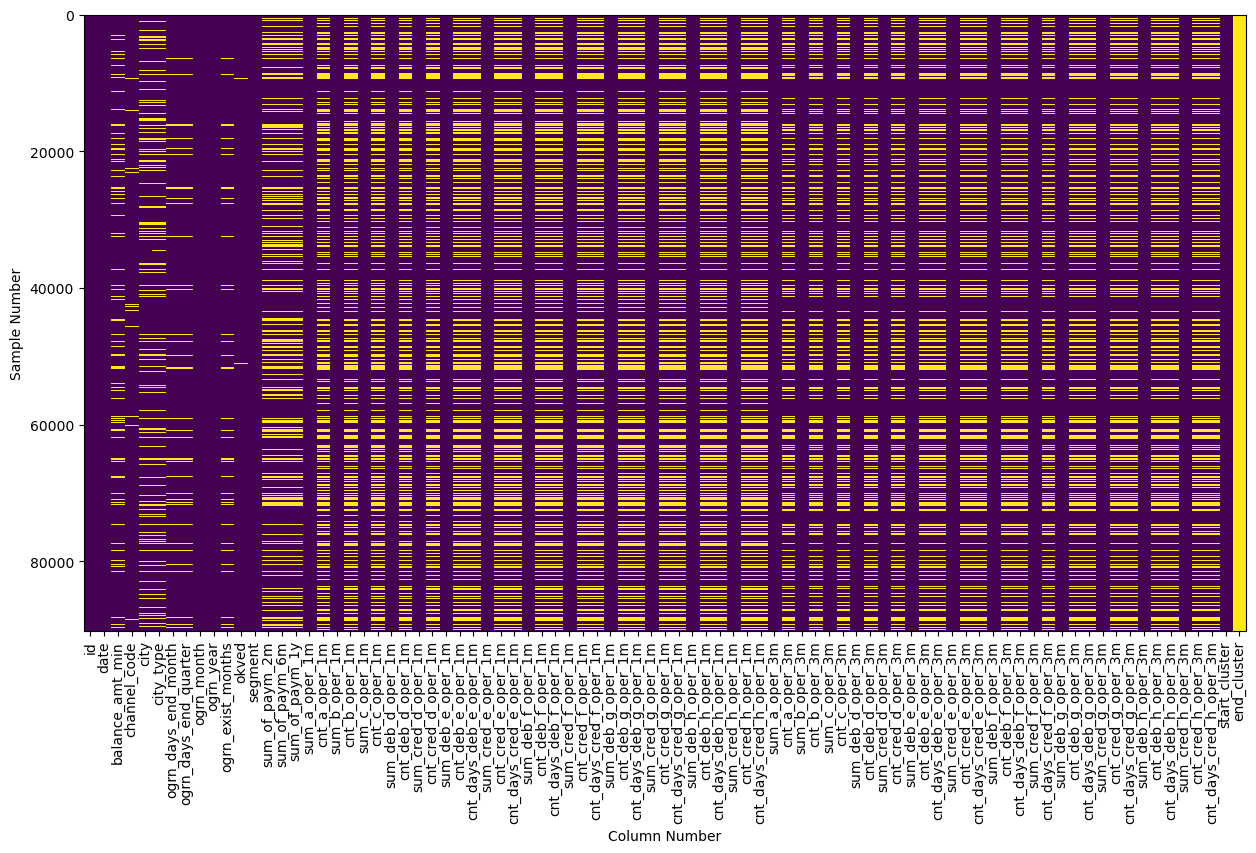

In [220]:
plt_null_df(df[df['date'] == 'month_4'].isna())

In [222]:
df[df['id'] > 199999].info()

<class 'pandas.core.frame.DataFrame'>
Index: 290120 entries, 600000 to 890119
Data columns (total 85 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       290120 non-null  int64   
 1   date                     290120 non-null  object  
 2   balance_amt_min          260637 non-null  float64 
 3   channel_code             283843 non-null  object  
 4   city                     241591 non-null  object  
 5   city_type                241255 non-null  object  
 6   ogrn_days_end_month      275842 non-null  float64 
 7   ogrn_days_end_quarter    275842 non-null  float64 
 8   ogrn_month               289816 non-null  category
 9   ogrn_year                289816 non-null  category
 10  ogrn_exist_months        275842 non-null  float64 
 11  okved                    289623 non-null  object  
 12  segment                  290100 non-null  category
 13  sum_of_paym_2m           216659 non-null  fl